In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'exclude'       : ['normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_0_0_0_1_normalized_e_n_e_0_0_e_0_0_basal_seg_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1078212, 828)
(1078212, 3)
validation
(151755, 828)
(151755, 3)
test
(135990, 828)
(135990, 3)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 1538307 (5.87 MB)


Trainable params: 1538307 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/108 [..............................] - ETA: 2:52 - loss: 1.1253 - STD: 0.0750 - MAE: 0.4442

  4/108 [>.............................] - ETA: 2s - loss: 1.1233 - STD: 0.0722 - MAE: 0.4434  

  7/108 [>.............................] - ETA: 2s - loss: 1.1108 - STD: 0.0711 - MAE: 0.4413

 10/108 [=>............................] - ETA: 2s - loss: 1.0915 - STD: 0.0616 - MAE: 0.4382

 13/108 [==>...........................] - ETA: 2s - loss: 1.0644 - STD: 0.0642 - MAE: 0.4321

 16/108 [===>..........................] - ETA: 2s - loss: 1.0252 - STD: 0.0768 - MAE: 0.4210

 19/108 [====>.........................] - ETA: 2s - loss: 0.9806 - STD: 0.0971 - MAE: 0.4064

 22/108 [=====>........................] - ETA: 1s - loss: 0.9392 - STD: 0.1190 - MAE: 0.3913

 25/108 [=====>........................] - ETA: 1s - loss: 0.9062 - STD: 0.1389 - MAE: 0.3778

 28/108 [======>.......................] - ETA: 1s - loss: 0.8783 - STD: 0.1561 - MAE: 0.3658

 31/108 [=======>......................] - ETA: 1s - loss: 0.8548 - STD: 0.1702 - MAE: 0.3557

 34/108 [========>.....................] - ETA: 1s - loss: 0.8326 - STD: 0.1814 - MAE: 0.3470

 37/108 [=========>....................] - ETA: 1s - loss: 0.8126 - STD: 0.1906 - MAE: 0.3394

 40/108 [==========>...................] - ETA: 1s - loss: 0.7943 - STD: 0.1988 - MAE: 0.3325

 43/108 [==========>...................] - ETA: 1s - loss: 0.7767 - STD: 0.2065 - MAE: 0.3257

 46/108 [===========>..................] - ETA: 1s - loss: 0.7600 - STD: 0.2144 - MAE: 0.3186

 49/108 [============>.................] - ETA: 1s - loss: 0.7443 - STD: 0.2219 - MAE: 0.3118

 52/108 [=============>................] - ETA: 1s - loss: 0.7290 - STD: 0.2292 - MAE: 0.3050

 55/108 [==============>...............] - ETA: 1s - loss: 0.7136 - STD: 0.2358 - MAE: 0.2984

 58/108 [===============>..............] - ETA: 1s - loss: 0.6987 - STD: 0.2420 - MAE: 0.2921

 61/108 [===============>..............] - ETA: 1s - loss: 0.6831 - STD: 0.2479 - MAE: 0.2855

 64/108 [================>.............] - ETA: 1s - loss: 0.6682 - STD: 0.2539 - MAE: 0.2790

 67/108 [=================>............] - ETA: 0s - loss: 0.6529 - STD: 0.2599 - MAE: 0.2723

 70/108 [==================>...........] - ETA: 0s - loss: 0.6384 - STD: 0.2659 - MAE: 0.2658

 73/108 [===================>..........] - ETA: 0s - loss: 0.6242 - STD: 0.2716 - MAE: 0.2594

 76/108 [====================>.........] - ETA: 0s - loss: 0.6108 - STD: 0.2770 - MAE: 0.2534

 79/108 [====================>.........] - ETA: 0s - loss: 0.5983 - STD: 0.2821 - MAE: 0.2477

 82/108 [=====================>........] - ETA: 0s - loss: 0.5866 - STD: 0.2868 - MAE: 0.2425

 85/108 [======================>.......] - ETA: 0s - loss: 0.5754 - STD: 0.2913 - MAE: 0.2375

 88/108 [=======================>......] - ETA: 0s - loss: 0.5651 - STD: 0.2955 - MAE: 0.2328

 91/108 [========================>.....] - ETA: 0s - loss: 0.5553 - STD: 0.2995 - MAE: 0.2284

 94/108 [=========================>....] - ETA: 0s - loss: 0.5457 - STD: 0.3033 - MAE: 0.2241

 97/108 [=========================>....] - ETA: 0s - loss: 0.5367 - STD: 0.3069 - MAE: 0.2200

100/108 [==========================>...] - ETA: 0s - loss: 0.5281 - STD: 0.3102 - MAE: 0.2163

101/108 [===========================>..] - ETA: 0s - loss: 0.5258 - STD: 0.3113 - MAE: 0.2150

104/108 [===========================>..] - ETA: 0s - loss: 0.5179 - STD: 0.3143 - MAE: 0.2116

107/108 [============================>.] - ETA: 0s - loss: 0.5101 - STD: 0.3172 - MAE: 0.2082

108/108 [==============================] - 6s 40ms/step - loss: 0.5077 - STD: 0.3181 - MAE: 0.2071 - val_loss: 0.2443 - val_STD: 0.4151 - val_MAE: 0.0961


Epoch 2/10000


  1/108 [..............................] - ETA: 5s - loss: 0.2463 - STD: 0.4178 - MAE: 0.0932

  4/108 [>.............................] - ETA: 2s - loss: 0.2455 - STD: 0.4184 - MAE: 0.0920

  7/108 [>.............................] - ETA: 2s - loss: 0.2415 - STD: 0.4191 - MAE: 0.0908

 10/108 [=>............................] - ETA: 2s - loss: 0.2407 - STD: 0.4196 - MAE: 0.0903

 13/108 [==>...........................] - ETA: 2s - loss: 0.2401 - STD: 0.4198 - MAE: 0.0901

 16/108 [===>..........................] - ETA: 2s - loss: 0.2396 - STD: 0.4202 - MAE: 0.0897

 19/108 [====>.........................] - ETA: 2s - loss: 0.2381 - STD: 0.4205 - MAE: 0.0891

 22/108 [=====>........................] - ETA: 1s - loss: 0.2370 - STD: 0.4208 - MAE: 0.0886

 25/108 [=====>........................] - ETA: 1s - loss: 0.2358 - STD: 0.4212 - MAE: 0.0881

 28/108 [======>.......................] - ETA: 1s - loss: 0.2349 - STD: 0.4215 - MAE: 0.0877

 31/108 [=======>......................] - ETA: 1s - loss: 0.2336 - STD: 0.4217 - MAE: 0.0873

 34/108 [========>.....................] - ETA: 1s - loss: 0.2335 - STD: 0.4218 - MAE: 0.0872

 37/108 [=========>....................] - ETA: 1s - loss: 0.2328 - STD: 0.4219 - MAE: 0.0869

 40/108 [==========>...................] - ETA: 1s - loss: 0.2318 - STD: 0.4221 - MAE: 0.0866

 43/108 [==========>...................] - ETA: 1s - loss: 0.2306 - STD: 0.4224 - MAE: 0.0862

 46/108 [===========>..................] - ETA: 1s - loss: 0.2299 - STD: 0.4226 - MAE: 0.0859

 49/108 [============>.................] - ETA: 1s - loss: 0.2289 - STD: 0.4228 - MAE: 0.0855

 52/108 [=============>................] - ETA: 1s - loss: 0.2281 - STD: 0.4230 - MAE: 0.0852

 55/108 [==============>...............] - ETA: 1s - loss: 0.2274 - STD: 0.4232 - MAE: 0.0849

 58/108 [===============>..............] - ETA: 1s - loss: 0.2265 - STD: 0.4234 - MAE: 0.0845

 61/108 [===============>..............] - ETA: 1s - loss: 0.2259 - STD: 0.4236 - MAE: 0.0842

 64/108 [================>.............] - ETA: 1s - loss: 0.2248 - STD: 0.4238 - MAE: 0.0838

 67/108 [=================>............] - ETA: 0s - loss: 0.2240 - STD: 0.4240 - MAE: 0.0835

 70/108 [==================>...........] - ETA: 0s - loss: 0.2232 - STD: 0.4242 - MAE: 0.0832

 73/108 [===================>..........] - ETA: 0s - loss: 0.2222 - STD: 0.4244 - MAE: 0.0828

 76/108 [====================>.........] - ETA: 0s - loss: 0.2215 - STD: 0.4246 - MAE: 0.0825

 79/108 [====================>.........] - ETA: 0s - loss: 0.2210 - STD: 0.4247 - MAE: 0.0823

 82/108 [=====================>........] - ETA: 0s - loss: 0.2203 - STD: 0.4249 - MAE: 0.0820

 85/108 [======================>.......] - ETA: 0s - loss: 0.2198 - STD: 0.4251 - MAE: 0.0818

 88/108 [=======================>......] - ETA: 0s - loss: 0.2193 - STD: 0.4252 - MAE: 0.0816

 91/108 [========================>.....] - ETA: 0s - loss: 0.2186 - STD: 0.4254 - MAE: 0.0813

 94/108 [=========================>....] - ETA: 0s - loss: 0.2180 - STD: 0.4256 - MAE: 0.0811

 97/108 [=========================>....] - ETA: 0s - loss: 0.2173 - STD: 0.4257 - MAE: 0.0808

100/108 [==========================>...] - ETA: 0s - loss: 0.2170 - STD: 0.4258 - MAE: 0.0806

103/108 [===========================>..] - ETA: 0s - loss: 0.2164 - STD: 0.4260 - MAE: 0.0804

106/108 [============================>.] - ETA: 0s - loss: 0.2159 - STD: 0.4261 - MAE: 0.0802

108/108 [==============================] - 3s 26ms/step - loss: 0.2154 - STD: 0.4262 - MAE: 0.0800 - val_loss: 0.2097 - val_STD: 0.4325 - val_MAE: 0.0736


Epoch 3/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1946 - STD: 0.4312 - MAE: 0.0713

  4/108 [>.............................] - ETA: 2s - loss: 0.1994 - STD: 0.4313 - MAE: 0.0726

  7/108 [>.............................] - ETA: 2s - loss: 0.1947 - STD: 0.4318 - MAE: 0.0712

 10/108 [=>............................] - ETA: 2s - loss: 0.1943 - STD: 0.4320 - MAE: 0.0711

 13/108 [==>...........................] - ETA: 2s - loss: 0.1945 - STD: 0.4319 - MAE: 0.0711

 16/108 [===>..........................] - ETA: 2s - loss: 0.1938 - STD: 0.4319 - MAE: 0.0709

 19/108 [====>.........................] - ETA: 2s - loss: 0.1936 - STD: 0.4320 - MAE: 0.0709

 22/108 [=====>........................] - ETA: 1s - loss: 0.1928 - STD: 0.4320 - MAE: 0.0707

 25/108 [=====>........................] - ETA: 1s - loss: 0.1921 - STD: 0.4321 - MAE: 0.0705

 28/108 [======>.......................] - ETA: 1s - loss: 0.1914 - STD: 0.4322 - MAE: 0.0702

 31/108 [=======>......................] - ETA: 1s - loss: 0.1909 - STD: 0.4323 - MAE: 0.0700

 34/108 [========>.....................] - ETA: 1s - loss: 0.1914 - STD: 0.4323 - MAE: 0.0701

 37/108 [=========>....................] - ETA: 1s - loss: 0.1915 - STD: 0.4323 - MAE: 0.0701

 40/108 [==========>...................] - ETA: 1s - loss: 0.1921 - STD: 0.4324 - MAE: 0.0702

 43/108 [==========>...................] - ETA: 1s - loss: 0.1921 - STD: 0.4324 - MAE: 0.0702

 46/108 [===========>..................] - ETA: 1s - loss: 0.1918 - STD: 0.4325 - MAE: 0.0701

 49/108 [============>.................] - ETA: 1s - loss: 0.1912 - STD: 0.4325 - MAE: 0.0700

 52/108 [=============>................] - ETA: 1s - loss: 0.1912 - STD: 0.4326 - MAE: 0.0699

 55/108 [==============>...............] - ETA: 1s - loss: 0.1906 - STD: 0.4326 - MAE: 0.0698

 58/108 [===============>..............] - ETA: 1s - loss: 0.1901 - STD: 0.4327 - MAE: 0.0696

 61/108 [===============>..............] - ETA: 1s - loss: 0.1900 - STD: 0.4327 - MAE: 0.0695

 64/108 [================>.............] - ETA: 0s - loss: 0.1899 - STD: 0.4328 - MAE: 0.0695

 67/108 [=================>............] - ETA: 0s - loss: 0.1896 - STD: 0.4329 - MAE: 0.0694

 70/108 [==================>...........] - ETA: 0s - loss: 0.1896 - STD: 0.4330 - MAE: 0.0693

 73/108 [===================>..........] - ETA: 0s - loss: 0.1896 - STD: 0.4330 - MAE: 0.0692

 76/108 [====================>.........] - ETA: 0s - loss: 0.1898 - STD: 0.4330 - MAE: 0.0693

 79/108 [====================>.........] - ETA: 0s - loss: 0.1899 - STD: 0.4331 - MAE: 0.0693

 82/108 [=====================>........] - ETA: 0s - loss: 0.1900 - STD: 0.4331 - MAE: 0.0692

 85/108 [======================>.......] - ETA: 0s - loss: 0.1900 - STD: 0.4331 - MAE: 0.0692

 88/108 [=======================>......] - ETA: 0s - loss: 0.1897 - STD: 0.4331 - MAE: 0.0691

 91/108 [========================>.....] - ETA: 0s - loss: 0.1896 - STD: 0.4332 - MAE: 0.0691

 94/108 [=========================>....] - ETA: 0s - loss: 0.1895 - STD: 0.4332 - MAE: 0.0691

 97/108 [=========================>....] - ETA: 0s - loss: 0.1893 - STD: 0.4332 - MAE: 0.0691

100/108 [==========================>...] - ETA: 0s - loss: 0.1889 - STD: 0.4332 - MAE: 0.0690

103/108 [===========================>..] - ETA: 0s - loss: 0.1887 - STD: 0.4333 - MAE: 0.0689

106/108 [============================>.] - ETA: 0s - loss: 0.1883 - STD: 0.4333 - MAE: 0.0688

108/108 [==============================] - 3s 26ms/step - loss: 0.1881 - STD: 0.4333 - MAE: 0.0687 - val_loss: 0.1706 - val_STD: 0.4367 - val_MAE: 0.0631


Epoch 4/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1811 - STD: 0.4354 - MAE: 0.0658

  4/108 [>.............................] - ETA: 2s - loss: 0.1787 - STD: 0.4348 - MAE: 0.0657

  7/108 [>.............................] - ETA: 2s - loss: 0.1786 - STD: 0.4349 - MAE: 0.0656

 10/108 [=>............................] - ETA: 2s - loss: 0.1777 - STD: 0.4351 - MAE: 0.0653

 13/108 [==>...........................] - ETA: 2s - loss: 0.1796 - STD: 0.4351 - MAE: 0.0656

 16/108 [===>..........................] - ETA: 2s - loss: 0.1805 - STD: 0.4353 - MAE: 0.0656

 19/108 [====>.........................] - ETA: 2s - loss: 0.1807 - STD: 0.4353 - MAE: 0.0656

 22/108 [=====>........................] - ETA: 1s - loss: 0.1814 - STD: 0.4354 - MAE: 0.0657

 25/108 [=====>........................] - ETA: 1s - loss: 0.1816 - STD: 0.4354 - MAE: 0.0658

 28/108 [======>.......................] - ETA: 1s - loss: 0.1817 - STD: 0.4353 - MAE: 0.0658

 31/108 [=======>......................] - ETA: 1s - loss: 0.1811 - STD: 0.4353 - MAE: 0.0657

 34/108 [========>.....................] - ETA: 1s - loss: 0.1803 - STD: 0.4354 - MAE: 0.0655

 37/108 [=========>....................] - ETA: 1s - loss: 0.1800 - STD: 0.4354 - MAE: 0.0654

 40/108 [==========>...................] - ETA: 1s - loss: 0.1796 - STD: 0.4354 - MAE: 0.0653

 43/108 [==========>...................] - ETA: 1s - loss: 0.1794 - STD: 0.4355 - MAE: 0.0653

 46/108 [===========>..................] - ETA: 1s - loss: 0.1795 - STD: 0.4355 - MAE: 0.0653

 49/108 [============>.................] - ETA: 1s - loss: 0.1799 - STD: 0.4354 - MAE: 0.0654

 52/108 [=============>................] - ETA: 1s - loss: 0.1805 - STD: 0.4354 - MAE: 0.0656

 55/108 [==============>...............] - ETA: 1s - loss: 0.1813 - STD: 0.4354 - MAE: 0.0657

 58/108 [===============>..............] - ETA: 1s - loss: 0.1811 - STD: 0.4354 - MAE: 0.0657

 61/108 [===============>..............] - ETA: 1s - loss: 0.1807 - STD: 0.4354 - MAE: 0.0656

 64/108 [================>.............] - ETA: 1s - loss: 0.1807 - STD: 0.4354 - MAE: 0.0656

 67/108 [=================>............] - ETA: 0s - loss: 0.1806 - STD: 0.4354 - MAE: 0.0655

 70/108 [==================>...........] - ETA: 0s - loss: 0.1802 - STD: 0.4354 - MAE: 0.0655

 73/108 [===================>..........] - ETA: 0s - loss: 0.1801 - STD: 0.4354 - MAE: 0.0655

 76/108 [====================>.........] - ETA: 0s - loss: 0.1799 - STD: 0.4354 - MAE: 0.0654

 79/108 [====================>.........] - ETA: 0s - loss: 0.1800 - STD: 0.4355 - MAE: 0.0654

 82/108 [=====================>........] - ETA: 0s - loss: 0.1800 - STD: 0.4355 - MAE: 0.0654

 85/108 [======================>.......] - ETA: 0s - loss: 0.1797 - STD: 0.4355 - MAE: 0.0653

 88/108 [=======================>......] - ETA: 0s - loss: 0.1794 - STD: 0.4355 - MAE: 0.0653

 91/108 [========================>.....] - ETA: 0s - loss: 0.1792 - STD: 0.4355 - MAE: 0.0652

 94/108 [=========================>....] - ETA: 0s - loss: 0.1789 - STD: 0.4355 - MAE: 0.0651

 97/108 [=========================>....] - ETA: 0s - loss: 0.1786 - STD: 0.4356 - MAE: 0.0650

100/108 [==========================>...] - ETA: 0s - loss: 0.1785 - STD: 0.4356 - MAE: 0.0649

103/108 [===========================>..] - ETA: 0s - loss: 0.1783 - STD: 0.4357 - MAE: 0.0649

106/108 [============================>.] - ETA: 0s - loss: 0.1781 - STD: 0.4357 - MAE: 0.0648

108/108 [==============================] - 3s 26ms/step - loss: 0.1781 - STD: 0.4358 - MAE: 0.0648 - val_loss: 0.1939 - val_STD: 0.4341 - val_MAE: 0.0694


Epoch 5/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1859 - STD: 0.4341 - MAE: 0.0681

  4/108 [>.............................] - ETA: 2s - loss: 0.1719 - STD: 0.4364 - MAE: 0.0631

  7/108 [>.............................] - ETA: 2s - loss: 0.1710 - STD: 0.4370 - MAE: 0.0625

 10/108 [=>............................] - ETA: 2s - loss: 0.1723 - STD: 0.4370 - MAE: 0.0627

 13/108 [==>...........................] - ETA: 2s - loss: 0.1722 - STD: 0.4369 - MAE: 0.0628

 16/108 [===>..........................] - ETA: 2s - loss: 0.1715 - STD: 0.4368 - MAE: 0.0627

 19/108 [====>.........................] - ETA: 2s - loss: 0.1725 - STD: 0.4367 - MAE: 0.0630

 22/108 [=====>........................] - ETA: 1s - loss: 0.1722 - STD: 0.4369 - MAE: 0.0628

 25/108 [=====>........................] - ETA: 1s - loss: 0.1717 - STD: 0.4369 - MAE: 0.0627

 28/108 [======>.......................] - ETA: 1s - loss: 0.1714 - STD: 0.4369 - MAE: 0.0626

 31/108 [=======>......................] - ETA: 1s - loss: 0.1713 - STD: 0.4370 - MAE: 0.0626

 34/108 [========>.....................] - ETA: 1s - loss: 0.1714 - STD: 0.4370 - MAE: 0.0625

 37/108 [=========>....................] - ETA: 1s - loss: 0.1712 - STD: 0.4371 - MAE: 0.0624

 40/108 [==========>...................] - ETA: 1s - loss: 0.1709 - STD: 0.4371 - MAE: 0.0623

 43/108 [==========>...................] - ETA: 1s - loss: 0.1714 - STD: 0.4371 - MAE: 0.0624

 46/108 [===========>..................] - ETA: 1s - loss: 0.1719 - STD: 0.4371 - MAE: 0.0626

 49/108 [============>.................] - ETA: 1s - loss: 0.1722 - STD: 0.4370 - MAE: 0.0627

 52/108 [=============>................] - ETA: 1s - loss: 0.1723 - STD: 0.4370 - MAE: 0.0627

 55/108 [==============>...............] - ETA: 1s - loss: 0.1721 - STD: 0.4369 - MAE: 0.0627

 58/108 [===============>..............] - ETA: 1s - loss: 0.1720 - STD: 0.4370 - MAE: 0.0627

 61/108 [===============>..............] - ETA: 1s - loss: 0.1720 - STD: 0.4370 - MAE: 0.0627

 64/108 [================>.............] - ETA: 0s - loss: 0.1717 - STD: 0.4370 - MAE: 0.0626

 67/108 [=================>............] - ETA: 0s - loss: 0.1716 - STD: 0.4370 - MAE: 0.0625

 70/108 [==================>...........] - ETA: 0s - loss: 0.1716 - STD: 0.4371 - MAE: 0.0625

 73/108 [===================>..........] - ETA: 0s - loss: 0.1719 - STD: 0.4371 - MAE: 0.0625

 76/108 [====================>.........] - ETA: 0s - loss: 0.1720 - STD: 0.4371 - MAE: 0.0625

 79/108 [====================>.........] - ETA: 0s - loss: 0.1722 - STD: 0.4371 - MAE: 0.0626

 82/108 [=====================>........] - ETA: 0s - loss: 0.1723 - STD: 0.4371 - MAE: 0.0626

 85/108 [======================>.......] - ETA: 0s - loss: 0.1724 - STD: 0.4371 - MAE: 0.0626

 88/108 [=======================>......] - ETA: 0s - loss: 0.1723 - STD: 0.4370 - MAE: 0.0626

 91/108 [========================>.....] - ETA: 0s - loss: 0.1720 - STD: 0.4370 - MAE: 0.0626

 94/108 [=========================>....] - ETA: 0s - loss: 0.1720 - STD: 0.4371 - MAE: 0.0626

 97/108 [=========================>....] - ETA: 0s - loss: 0.1716 - STD: 0.4371 - MAE: 0.0625

100/108 [==========================>...] - ETA: 0s - loss: 0.1714 - STD: 0.4371 - MAE: 0.0624

103/108 [===========================>..] - ETA: 0s - loss: 0.1713 - STD: 0.4371 - MAE: 0.0624

106/108 [============================>.] - ETA: 0s - loss: 0.1710 - STD: 0.4372 - MAE: 0.0623

108/108 [==============================] - 3s 26ms/step - loss: 0.1709 - STD: 0.4372 - MAE: 0.0622 - val_loss: 0.1595 - val_STD: 0.4406 - val_MAE: 0.0574


Epoch 6/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1624 - STD: 0.4399 - MAE: 0.0583

  4/108 [>.............................] - ETA: 2s - loss: 0.1654 - STD: 0.4387 - MAE: 0.0597

  7/108 [>.............................] - ETA: 2s - loss: 0.1659 - STD: 0.4389 - MAE: 0.0597

 10/108 [=>............................] - ETA: 2s - loss: 0.1655 - STD: 0.4387 - MAE: 0.0599

 13/108 [==>...........................] - ETA: 2s - loss: 0.1676 - STD: 0.4384 - MAE: 0.0605

 16/108 [===>..........................] - ETA: 2s - loss: 0.1682 - STD: 0.4383 - MAE: 0.0608

 19/108 [====>.........................] - ETA: 2s - loss: 0.1693 - STD: 0.4381 - MAE: 0.0611

 22/108 [=====>........................] - ETA: 1s - loss: 0.1702 - STD: 0.4381 - MAE: 0.0614

 25/108 [=====>........................] - ETA: 1s - loss: 0.1699 - STD: 0.4379 - MAE: 0.0614

 28/108 [======>.......................] - ETA: 1s - loss: 0.1694 - STD: 0.4378 - MAE: 0.0614

 31/108 [=======>......................] - ETA: 1s - loss: 0.1692 - STD: 0.4378 - MAE: 0.0614

 34/108 [========>.....................] - ETA: 1s - loss: 0.1690 - STD: 0.4379 - MAE: 0.0613

 37/108 [=========>....................] - ETA: 1s - loss: 0.1682 - STD: 0.4379 - MAE: 0.0611

 40/108 [==========>...................] - ETA: 1s - loss: 0.1689 - STD: 0.4379 - MAE: 0.0613

 43/108 [==========>...................] - ETA: 1s - loss: 0.1692 - STD: 0.4378 - MAE: 0.0614

 46/108 [===========>..................] - ETA: 1s - loss: 0.1690 - STD: 0.4379 - MAE: 0.0614

 49/108 [============>.................] - ETA: 1s - loss: 0.1690 - STD: 0.4379 - MAE: 0.0613

 52/108 [=============>................] - ETA: 1s - loss: 0.1691 - STD: 0.4379 - MAE: 0.0614

 55/108 [==============>...............] - ETA: 1s - loss: 0.1690 - STD: 0.4379 - MAE: 0.0613

 58/108 [===============>..............] - ETA: 1s - loss: 0.1693 - STD: 0.4379 - MAE: 0.0613

 61/108 [===============>..............] - ETA: 1s - loss: 0.1699 - STD: 0.4378 - MAE: 0.0615

 64/108 [================>.............] - ETA: 0s - loss: 0.1705 - STD: 0.4377 - MAE: 0.0617

 67/108 [=================>............] - ETA: 0s - loss: 0.1710 - STD: 0.4377 - MAE: 0.0618

 70/108 [==================>...........] - ETA: 0s - loss: 0.1708 - STD: 0.4378 - MAE: 0.0618

 73/108 [===================>..........] - ETA: 0s - loss: 0.1704 - STD: 0.4378 - MAE: 0.0616

 76/108 [====================>.........] - ETA: 0s - loss: 0.1704 - STD: 0.4378 - MAE: 0.0617

 79/108 [====================>.........] - ETA: 0s - loss: 0.1700 - STD: 0.4378 - MAE: 0.0616

 82/108 [=====================>........] - ETA: 0s - loss: 0.1697 - STD: 0.4378 - MAE: 0.0615

 85/108 [======================>.......] - ETA: 0s - loss: 0.1692 - STD: 0.4378 - MAE: 0.0615

 88/108 [=======================>......] - ETA: 0s - loss: 0.1689 - STD: 0.4378 - MAE: 0.0614

 91/108 [========================>.....] - ETA: 0s - loss: 0.1687 - STD: 0.4378 - MAE: 0.0613

 94/108 [=========================>....] - ETA: 0s - loss: 0.1685 - STD: 0.4379 - MAE: 0.0612

 97/108 [=========================>....] - ETA: 0s - loss: 0.1684 - STD: 0.4379 - MAE: 0.0612

100/108 [==========================>...] - ETA: 0s - loss: 0.1681 - STD: 0.4380 - MAE: 0.0611

103/108 [===========================>..] - ETA: 0s - loss: 0.1680 - STD: 0.4380 - MAE: 0.0611

106/108 [============================>.] - ETA: 0s - loss: 0.1680 - STD: 0.4380 - MAE: 0.0610

108/108 [==============================] - 3s 25ms/step - loss: 0.1679 - STD: 0.4380 - MAE: 0.0610 - val_loss: 0.1733 - val_STD: 0.4412 - val_MAE: 0.0588


Epoch 7/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1632 - STD: 0.4405 - MAE: 0.0578

  4/108 [>.............................] - ETA: 2s - loss: 0.1644 - STD: 0.4393 - MAE: 0.0592

  7/108 [>.............................] - ETA: 2s - loss: 0.1613 - STD: 0.4391 - MAE: 0.0589

 10/108 [=>............................] - ETA: 2s - loss: 0.1627 - STD: 0.4391 - MAE: 0.0591

 13/108 [==>...........................] - ETA: 2s - loss: 0.1648 - STD: 0.4388 - MAE: 0.0598

 16/108 [===>..........................] - ETA: 2s - loss: 0.1662 - STD: 0.4387 - MAE: 0.0601

 19/108 [====>.........................] - ETA: 2s - loss: 0.1666 - STD: 0.4387 - MAE: 0.0602

 22/108 [=====>........................] - ETA: 1s - loss: 0.1673 - STD: 0.4386 - MAE: 0.0604

 25/108 [=====>........................] - ETA: 1s - loss: 0.1666 - STD: 0.4385 - MAE: 0.0603

 28/108 [======>.......................] - ETA: 1s - loss: 0.1666 - STD: 0.4385 - MAE: 0.0603

 31/108 [=======>......................] - ETA: 1s - loss: 0.1673 - STD: 0.4386 - MAE: 0.0605

 34/108 [========>.....................] - ETA: 1s - loss: 0.1677 - STD: 0.4385 - MAE: 0.0606

 37/108 [=========>....................] - ETA: 1s - loss: 0.1687 - STD: 0.4385 - MAE: 0.0608

 40/108 [==========>...................] - ETA: 1s - loss: 0.1683 - STD: 0.4384 - MAE: 0.0608

 43/108 [==========>...................] - ETA: 1s - loss: 0.1682 - STD: 0.4384 - MAE: 0.0608

 46/108 [===========>..................] - ETA: 1s - loss: 0.1680 - STD: 0.4383 - MAE: 0.0608

 49/108 [============>.................] - ETA: 1s - loss: 0.1675 - STD: 0.4384 - MAE: 0.0607

 52/108 [=============>................] - ETA: 1s - loss: 0.1677 - STD: 0.4384 - MAE: 0.0608

 55/108 [==============>...............] - ETA: 1s - loss: 0.1676 - STD: 0.4384 - MAE: 0.0608

 58/108 [===============>..............] - ETA: 1s - loss: 0.1673 - STD: 0.4383 - MAE: 0.0607

 61/108 [===============>..............] - ETA: 1s - loss: 0.1674 - STD: 0.4383 - MAE: 0.0607

 64/108 [================>.............] - ETA: 1s - loss: 0.1673 - STD: 0.4383 - MAE: 0.0608

 67/108 [=================>............] - ETA: 0s - loss: 0.1669 - STD: 0.4383 - MAE: 0.0606

 70/108 [==================>...........] - ETA: 0s - loss: 0.1669 - STD: 0.4384 - MAE: 0.0606

 73/108 [===================>..........] - ETA: 0s - loss: 0.1665 - STD: 0.4384 - MAE: 0.0605

 76/108 [====================>.........] - ETA: 0s - loss: 0.1663 - STD: 0.4384 - MAE: 0.0605

 79/108 [====================>.........] - ETA: 0s - loss: 0.1660 - STD: 0.4384 - MAE: 0.0604

 82/108 [=====================>........] - ETA: 0s - loss: 0.1659 - STD: 0.4384 - MAE: 0.0604

 85/108 [======================>.......] - ETA: 0s - loss: 0.1657 - STD: 0.4385 - MAE: 0.0602

 88/108 [=======================>......] - ETA: 0s - loss: 0.1652 - STD: 0.4385 - MAE: 0.0602

 91/108 [========================>.....] - ETA: 0s - loss: 0.1654 - STD: 0.4385 - MAE: 0.0602

 94/108 [=========================>....] - ETA: 0s - loss: 0.1652 - STD: 0.4385 - MAE: 0.0601

 97/108 [=========================>....] - ETA: 0s - loss: 0.1650 - STD: 0.4386 - MAE: 0.0601

100/108 [==========================>...] - ETA: 0s - loss: 0.1651 - STD: 0.4386 - MAE: 0.0601

103/108 [===========================>..] - ETA: 0s - loss: 0.1655 - STD: 0.4386 - MAE: 0.0601

106/108 [============================>.] - ETA: 0s - loss: 0.1659 - STD: 0.4386 - MAE: 0.0602

108/108 [==============================] - 3s 25ms/step - loss: 0.1661 - STD: 0.4386 - MAE: 0.0602 - val_loss: 0.1840 - val_STD: 0.4406 - val_MAE: 0.0613


Epoch 8/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1652 - STD: 0.4408 - MAE: 0.0578

  4/108 [>.............................] - ETA: 2s - loss: 0.1648 - STD: 0.4390 - MAE: 0.0597

  7/108 [>.............................] - ETA: 2s - loss: 0.1625 - STD: 0.4384 - MAE: 0.0599

 10/108 [=>............................] - ETA: 2s - loss: 0.1612 - STD: 0.4381 - MAE: 0.0598

 13/108 [==>...........................] - ETA: 2s - loss: 0.1610 - STD: 0.4383 - MAE: 0.0596

 16/108 [===>..........................] - ETA: 2s - loss: 0.1598 - STD: 0.4384 - MAE: 0.0593

 19/108 [====>.........................] - ETA: 2s - loss: 0.1592 - STD: 0.4384 - MAE: 0.0591

 22/108 [=====>........................] - ETA: 1s - loss: 0.1591 - STD: 0.4385 - MAE: 0.0591

 25/108 [=====>........................] - ETA: 1s - loss: 0.1603 - STD: 0.4385 - MAE: 0.0593

 28/108 [======>.......................] - ETA: 1s - loss: 0.1608 - STD: 0.4385 - MAE: 0.0594

 31/108 [=======>......................] - ETA: 1s - loss: 0.1614 - STD: 0.4386 - MAE: 0.0594

 34/108 [========>.....................] - ETA: 1s - loss: 0.1617 - STD: 0.4387 - MAE: 0.0594

 37/108 [=========>....................] - ETA: 1s - loss: 0.1613 - STD: 0.4387 - MAE: 0.0593

 40/108 [==========>...................] - ETA: 1s - loss: 0.1613 - STD: 0.4387 - MAE: 0.0592

 43/108 [==========>...................] - ETA: 1s - loss: 0.1609 - STD: 0.4388 - MAE: 0.0591

 46/108 [===========>..................] - ETA: 1s - loss: 0.1609 - STD: 0.4388 - MAE: 0.0591

 49/108 [============>.................] - ETA: 1s - loss: 0.1609 - STD: 0.4389 - MAE: 0.0591

 52/108 [=============>................] - ETA: 1s - loss: 0.1606 - STD: 0.4389 - MAE: 0.0590

 55/108 [==============>...............] - ETA: 1s - loss: 0.1605 - STD: 0.4389 - MAE: 0.0590

 58/108 [===============>..............] - ETA: 1s - loss: 0.1602 - STD: 0.4389 - MAE: 0.0589

 61/108 [===============>..............] - ETA: 1s - loss: 0.1602 - STD: 0.4390 - MAE: 0.0589

 64/108 [================>.............] - ETA: 1s - loss: 0.1604 - STD: 0.4390 - MAE: 0.0589

 67/108 [=================>............] - ETA: 0s - loss: 0.1607 - STD: 0.4391 - MAE: 0.0589

 70/108 [==================>...........] - ETA: 0s - loss: 0.1608 - STD: 0.4391 - MAE: 0.0589

 73/108 [===================>..........] - ETA: 0s - loss: 0.1609 - STD: 0.4391 - MAE: 0.0589

 76/108 [====================>.........] - ETA: 0s - loss: 0.1610 - STD: 0.4392 - MAE: 0.0588

 79/108 [====================>.........] - ETA: 0s - loss: 0.1610 - STD: 0.4392 - MAE: 0.0588

 82/108 [=====================>........] - ETA: 0s - loss: 0.1609 - STD: 0.4392 - MAE: 0.0588

 85/108 [======================>.......] - ETA: 0s - loss: 0.1611 - STD: 0.4391 - MAE: 0.0589

 88/108 [=======================>......] - ETA: 0s - loss: 0.1611 - STD: 0.4391 - MAE: 0.0589

 91/108 [========================>.....] - ETA: 0s - loss: 0.1609 - STD: 0.4392 - MAE: 0.0588

 94/108 [=========================>....] - ETA: 0s - loss: 0.1609 - STD: 0.4392 - MAE: 0.0588

 97/108 [=========================>....] - ETA: 0s - loss: 0.1609 - STD: 0.4392 - MAE: 0.0588

100/108 [==========================>...] - ETA: 0s - loss: 0.1606 - STD: 0.4392 - MAE: 0.0588

103/108 [===========================>..] - ETA: 0s - loss: 0.1605 - STD: 0.4392 - MAE: 0.0587

106/108 [============================>.] - ETA: 0s - loss: 0.1604 - STD: 0.4392 - MAE: 0.0587

108/108 [==============================] - 3s 26ms/step - loss: 0.1605 - STD: 0.4392 - MAE: 0.0587 - val_loss: 0.1473 - val_STD: 0.4413 - val_MAE: 0.0553


Epoch 9/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1644 - STD: 0.4402 - MAE: 0.0588

  4/108 [>.............................] - ETA: 2s - loss: 0.1603 - STD: 0.4396 - MAE: 0.0583

  7/108 [>.............................] - ETA: 2s - loss: 0.1594 - STD: 0.4395 - MAE: 0.0582

 10/108 [=>............................] - ETA: 2s - loss: 0.1595 - STD: 0.4393 - MAE: 0.0584

 13/108 [==>...........................] - ETA: 2s - loss: 0.1598 - STD: 0.4394 - MAE: 0.0584

 16/108 [===>..........................] - ETA: 2s - loss: 0.1591 - STD: 0.4394 - MAE: 0.0583

 19/108 [====>.........................] - ETA: 2s - loss: 0.1601 - STD: 0.4394 - MAE: 0.0584

 22/108 [=====>........................] - ETA: 1s - loss: 0.1599 - STD: 0.4395 - MAE: 0.0584

 25/108 [=====>........................] - ETA: 1s - loss: 0.1601 - STD: 0.4396 - MAE: 0.0583

 28/108 [======>.......................] - ETA: 1s - loss: 0.1598 - STD: 0.4396 - MAE: 0.0583

 31/108 [=======>......................] - ETA: 1s - loss: 0.1597 - STD: 0.4396 - MAE: 0.0582

 34/108 [========>.....................] - ETA: 1s - loss: 0.1605 - STD: 0.4396 - MAE: 0.0584

 37/108 [=========>....................] - ETA: 1s - loss: 0.1607 - STD: 0.4396 - MAE: 0.0584

 40/108 [==========>...................] - ETA: 1s - loss: 0.1604 - STD: 0.4396 - MAE: 0.0584

 43/108 [==========>...................] - ETA: 1s - loss: 0.1602 - STD: 0.4396 - MAE: 0.0584

 46/108 [===========>..................] - ETA: 1s - loss: 0.1606 - STD: 0.4395 - MAE: 0.0585

 49/108 [============>.................] - ETA: 1s - loss: 0.1603 - STD: 0.4395 - MAE: 0.0585

 52/108 [=============>................] - ETA: 1s - loss: 0.1599 - STD: 0.4395 - MAE: 0.0584

 55/108 [==============>...............] - ETA: 1s - loss: 0.1595 - STD: 0.4395 - MAE: 0.0583

 58/108 [===============>..............] - ETA: 1s - loss: 0.1595 - STD: 0.4396 - MAE: 0.0583

 61/108 [===============>..............] - ETA: 1s - loss: 0.1594 - STD: 0.4396 - MAE: 0.0582

 64/108 [================>.............] - ETA: 1s - loss: 0.1592 - STD: 0.4396 - MAE: 0.0582

 67/108 [=================>............] - ETA: 0s - loss: 0.1589 - STD: 0.4396 - MAE: 0.0581

 70/108 [==================>...........] - ETA: 0s - loss: 0.1588 - STD: 0.4396 - MAE: 0.0581

 73/108 [===================>..........] - ETA: 0s - loss: 0.1588 - STD: 0.4396 - MAE: 0.0581

 76/108 [====================>.........] - ETA: 0s - loss: 0.1587 - STD: 0.4397 - MAE: 0.0581

 79/108 [====================>.........] - ETA: 0s - loss: 0.1587 - STD: 0.4397 - MAE: 0.0580

 82/108 [=====================>........] - ETA: 0s - loss: 0.1587 - STD: 0.4397 - MAE: 0.0580

 85/108 [======================>.......] - ETA: 0s - loss: 0.1589 - STD: 0.4398 - MAE: 0.0580

 88/108 [=======================>......] - ETA: 0s - loss: 0.1588 - STD: 0.4398 - MAE: 0.0579

 91/108 [========================>.....] - ETA: 0s - loss: 0.1588 - STD: 0.4398 - MAE: 0.0579

 94/108 [=========================>....] - ETA: 0s - loss: 0.1586 - STD: 0.4398 - MAE: 0.0579

 97/108 [=========================>....] - ETA: 0s - loss: 0.1584 - STD: 0.4399 - MAE: 0.0578

100/108 [==========================>...] - ETA: 0s - loss: 0.1582 - STD: 0.4399 - MAE: 0.0578

103/108 [===========================>..] - ETA: 0s - loss: 0.1581 - STD: 0.4398 - MAE: 0.0578

106/108 [============================>.] - ETA: 0s - loss: 0.1581 - STD: 0.4398 - MAE: 0.0578

108/108 [==============================] - 3s 26ms/step - loss: 0.1580 - STD: 0.4398 - MAE: 0.0577 - val_loss: 0.1679 - val_STD: 0.4405 - val_MAE: 0.0588


Epoch 10/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1417 - STD: 0.4400 - MAE: 0.0547

  4/108 [>.............................] - ETA: 2s - loss: 0.1490 - STD: 0.4409 - MAE: 0.0551

  7/108 [>.............................] - ETA: 2s - loss: 0.1508 - STD: 0.4408 - MAE: 0.0555

 10/108 [=>............................] - ETA: 2s - loss: 0.1513 - STD: 0.4407 - MAE: 0.0557

 13/108 [==>...........................] - ETA: 2s - loss: 0.1529 - STD: 0.4407 - MAE: 0.0560

 16/108 [===>..........................] - ETA: 2s - loss: 0.1529 - STD: 0.4409 - MAE: 0.0559

 19/108 [====>.........................] - ETA: 2s - loss: 0.1529 - STD: 0.4410 - MAE: 0.0558

 22/108 [=====>........................] - ETA: 1s - loss: 0.1533 - STD: 0.4409 - MAE: 0.0559

 25/108 [=====>........................] - ETA: 1s - loss: 0.1543 - STD: 0.4408 - MAE: 0.0562

 28/108 [======>.......................] - ETA: 1s - loss: 0.1543 - STD: 0.4408 - MAE: 0.0562

 31/108 [=======>......................] - ETA: 1s - loss: 0.1540 - STD: 0.4407 - MAE: 0.0562

 34/108 [========>.....................] - ETA: 1s - loss: 0.1539 - STD: 0.4407 - MAE: 0.0563

 37/108 [=========>....................] - ETA: 1s - loss: 0.1544 - STD: 0.4407 - MAE: 0.0564

 40/108 [==========>...................] - ETA: 1s - loss: 0.1547 - STD: 0.4406 - MAE: 0.0565

 43/108 [==========>...................] - ETA: 1s - loss: 0.1550 - STD: 0.4406 - MAE: 0.0566

 46/108 [===========>..................] - ETA: 1s - loss: 0.1556 - STD: 0.4405 - MAE: 0.0567

 49/108 [============>.................] - ETA: 1s - loss: 0.1555 - STD: 0.4406 - MAE: 0.0567

 52/108 [=============>................] - ETA: 1s - loss: 0.1554 - STD: 0.4405 - MAE: 0.0567

 55/108 [==============>...............] - ETA: 1s - loss: 0.1555 - STD: 0.4405 - MAE: 0.0567

 58/108 [===============>..............] - ETA: 1s - loss: 0.1558 - STD: 0.4405 - MAE: 0.0568

 61/108 [===============>..............] - ETA: 1s - loss: 0.1559 - STD: 0.4404 - MAE: 0.0569

 64/108 [================>.............] - ETA: 1s - loss: 0.1558 - STD: 0.4404 - MAE: 0.0569

 67/108 [=================>............] - ETA: 0s - loss: 0.1556 - STD: 0.4404 - MAE: 0.0568

 70/108 [==================>...........] - ETA: 0s - loss: 0.1554 - STD: 0.4404 - MAE: 0.0568

 73/108 [===================>..........] - ETA: 0s - loss: 0.1557 - STD: 0.4404 - MAE: 0.0569

 76/108 [====================>.........] - ETA: 0s - loss: 0.1556 - STD: 0.4404 - MAE: 0.0569

 79/108 [====================>.........] - ETA: 0s - loss: 0.1555 - STD: 0.4404 - MAE: 0.0568

 82/108 [=====================>........] - ETA: 0s - loss: 0.1554 - STD: 0.4404 - MAE: 0.0568

 85/108 [======================>.......] - ETA: 0s - loss: 0.1554 - STD: 0.4405 - MAE: 0.0568

 88/108 [=======================>......] - ETA: 0s - loss: 0.1552 - STD: 0.4405 - MAE: 0.0567

 91/108 [========================>.....] - ETA: 0s - loss: 0.1549 - STD: 0.4405 - MAE: 0.0567

 94/108 [=========================>....] - ETA: 0s - loss: 0.1546 - STD: 0.4405 - MAE: 0.0566

 97/108 [=========================>....] - ETA: 0s - loss: 0.1546 - STD: 0.4405 - MAE: 0.0565

100/108 [==========================>...] - ETA: 0s - loss: 0.1544 - STD: 0.4406 - MAE: 0.0565

103/108 [===========================>..] - ETA: 0s - loss: 0.1544 - STD: 0.4406 - MAE: 0.0565

106/108 [============================>.] - ETA: 0s - loss: 0.1548 - STD: 0.4406 - MAE: 0.0566

108/108 [==============================] - 3s 25ms/step - loss: 0.1550 - STD: 0.4406 - MAE: 0.0566 - val_loss: 0.1504 - val_STD: 0.4392 - val_MAE: 0.0584


Epoch 11/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1587 - STD: 0.4390 - MAE: 0.0588

  4/108 [>.............................] - ETA: 2s - loss: 0.1624 - STD: 0.4403 - MAE: 0.0583

  7/108 [>.............................] - ETA: 2s - loss: 0.1601 - STD: 0.4404 - MAE: 0.0577

 10/108 [=>............................] - ETA: 2s - loss: 0.1587 - STD: 0.4405 - MAE: 0.0574

 13/108 [==>...........................] - ETA: 2s - loss: 0.1592 - STD: 0.4403 - MAE: 0.0576

 16/108 [===>..........................] - ETA: 2s - loss: 0.1590 - STD: 0.4404 - MAE: 0.0575

 19/108 [====>.........................] - ETA: 2s - loss: 0.1588 - STD: 0.4403 - MAE: 0.0576

 22/108 [=====>........................] - ETA: 1s - loss: 0.1590 - STD: 0.4401 - MAE: 0.0578

 25/108 [=====>........................] - ETA: 1s - loss: 0.1578 - STD: 0.4401 - MAE: 0.0576

 28/108 [======>.......................] - ETA: 1s - loss: 0.1580 - STD: 0.4400 - MAE: 0.0577

 31/108 [=======>......................] - ETA: 1s - loss: 0.1589 - STD: 0.4400 - MAE: 0.0579

 34/108 [========>.....................] - ETA: 1s - loss: 0.1588 - STD: 0.4400 - MAE: 0.0579

 37/108 [=========>....................] - ETA: 1s - loss: 0.1588 - STD: 0.4399 - MAE: 0.0579

 40/108 [==========>...................] - ETA: 1s - loss: 0.1592 - STD: 0.4399 - MAE: 0.0580

 43/108 [==========>...................] - ETA: 1s - loss: 0.1589 - STD: 0.4400 - MAE: 0.0579

 46/108 [===========>..................] - ETA: 1s - loss: 0.1590 - STD: 0.4400 - MAE: 0.0579

 49/108 [============>.................] - ETA: 1s - loss: 0.1593 - STD: 0.4400 - MAE: 0.0580

 52/108 [=============>................] - ETA: 1s - loss: 0.1592 - STD: 0.4400 - MAE: 0.0580

 55/108 [==============>...............] - ETA: 1s - loss: 0.1590 - STD: 0.4400 - MAE: 0.0579

 58/108 [===============>..............] - ETA: 1s - loss: 0.1589 - STD: 0.4400 - MAE: 0.0579

 61/108 [===============>..............] - ETA: 1s - loss: 0.1590 - STD: 0.4400 - MAE: 0.0579

 64/108 [================>.............] - ETA: 0s - loss: 0.1585 - STD: 0.4401 - MAE: 0.0577

 67/108 [=================>............] - ETA: 0s - loss: 0.1587 - STD: 0.4400 - MAE: 0.0578

 70/108 [==================>...........] - ETA: 0s - loss: 0.1583 - STD: 0.4400 - MAE: 0.0577

 73/108 [===================>..........] - ETA: 0s - loss: 0.1579 - STD: 0.4401 - MAE: 0.0576

 76/108 [====================>.........] - ETA: 0s - loss: 0.1577 - STD: 0.4401 - MAE: 0.0575

 79/108 [====================>.........] - ETA: 0s - loss: 0.1573 - STD: 0.4402 - MAE: 0.0574

 82/108 [=====================>........] - ETA: 0s - loss: 0.1569 - STD: 0.4402 - MAE: 0.0573

 85/108 [======================>.......] - ETA: 0s - loss: 0.1568 - STD: 0.4402 - MAE: 0.0573

 88/108 [=======================>......] - ETA: 0s - loss: 0.1565 - STD: 0.4403 - MAE: 0.0572

 91/108 [========================>.....] - ETA: 0s - loss: 0.1562 - STD: 0.4403 - MAE: 0.0571

 94/108 [=========================>....] - ETA: 0s - loss: 0.1560 - STD: 0.4403 - MAE: 0.0570

 97/108 [=========================>....] - ETA: 0s - loss: 0.1557 - STD: 0.4403 - MAE: 0.0570

100/108 [==========================>...] - ETA: 0s - loss: 0.1556 - STD: 0.4404 - MAE: 0.0569

103/108 [===========================>..] - ETA: 0s - loss: 0.1555 - STD: 0.4404 - MAE: 0.0569

106/108 [============================>.] - ETA: 0s - loss: 0.1553 - STD: 0.4404 - MAE: 0.0568

108/108 [==============================] - 3s 25ms/step - loss: 0.1554 - STD: 0.4405 - MAE: 0.0568 - val_loss: 0.1615 - val_STD: 0.4407 - val_MAE: 0.0575


Epoch 12/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1554 - STD: 0.4391 - MAE: 0.0583

  4/108 [>.............................] - ETA: 2s - loss: 0.1519 - STD: 0.4408 - MAE: 0.0558

  7/108 [>.............................] - ETA: 2s - loss: 0.1546 - STD: 0.4409 - MAE: 0.0563

 10/108 [=>............................] - ETA: 2s - loss: 0.1556 - STD: 0.4409 - MAE: 0.0565

 13/108 [==>...........................] - ETA: 2s - loss: 0.1534 - STD: 0.4409 - MAE: 0.0561

 16/108 [===>..........................] - ETA: 2s - loss: 0.1530 - STD: 0.4407 - MAE: 0.0562

 19/108 [====>.........................] - ETA: 2s - loss: 0.1517 - STD: 0.4408 - MAE: 0.0558

 22/108 [=====>........................] - ETA: 1s - loss: 0.1512 - STD: 0.4408 - MAE: 0.0557

 25/108 [=====>........................] - ETA: 1s - loss: 0.1507 - STD: 0.4409 - MAE: 0.0555

 28/108 [======>.......................] - ETA: 1s - loss: 0.1502 - STD: 0.4410 - MAE: 0.0554

 31/108 [=======>......................] - ETA: 1s - loss: 0.1504 - STD: 0.4411 - MAE: 0.0554

 34/108 [========>.....................] - ETA: 1s - loss: 0.1498 - STD: 0.4412 - MAE: 0.0552

 37/108 [=========>....................] - ETA: 1s - loss: 0.1498 - STD: 0.4412 - MAE: 0.0552

 40/108 [==========>...................] - ETA: 1s - loss: 0.1498 - STD: 0.4412 - MAE: 0.0551

 43/108 [==========>...................] - ETA: 1s - loss: 0.1497 - STD: 0.4413 - MAE: 0.0551

 46/108 [===========>..................] - ETA: 1s - loss: 0.1497 - STD: 0.4412 - MAE: 0.0551

 49/108 [============>.................] - ETA: 1s - loss: 0.1493 - STD: 0.4413 - MAE: 0.0550

 52/108 [=============>................] - ETA: 1s - loss: 0.1489 - STD: 0.4414 - MAE: 0.0549

 55/108 [==============>...............] - ETA: 1s - loss: 0.1488 - STD: 0.4414 - MAE: 0.0548

 58/108 [===============>..............] - ETA: 1s - loss: 0.1488 - STD: 0.4415 - MAE: 0.0547

 61/108 [===============>..............] - ETA: 1s - loss: 0.1487 - STD: 0.4415 - MAE: 0.0547

 64/108 [================>.............] - ETA: 1s - loss: 0.1487 - STD: 0.4415 - MAE: 0.0547

 67/108 [=================>............] - ETA: 0s - loss: 0.1487 - STD: 0.4415 - MAE: 0.0546

 70/108 [==================>...........] - ETA: 0s - loss: 0.1490 - STD: 0.4415 - MAE: 0.0547

 73/108 [===================>..........] - ETA: 0s - loss: 0.1490 - STD: 0.4415 - MAE: 0.0547

 76/108 [====================>.........] - ETA: 0s - loss: 0.1491 - STD: 0.4415 - MAE: 0.0547

 79/108 [====================>.........] - ETA: 0s - loss: 0.1493 - STD: 0.4415 - MAE: 0.0548

 82/108 [=====================>........] - ETA: 0s - loss: 0.1492 - STD: 0.4415 - MAE: 0.0548

 85/108 [======================>.......] - ETA: 0s - loss: 0.1491 - STD: 0.4415 - MAE: 0.0547

 88/108 [=======================>......] - ETA: 0s - loss: 0.1491 - STD: 0.4416 - MAE: 0.0547

 91/108 [========================>.....] - ETA: 0s - loss: 0.1490 - STD: 0.4416 - MAE: 0.0546

 94/108 [=========================>....] - ETA: 0s - loss: 0.1489 - STD: 0.4416 - MAE: 0.0546

 97/108 [=========================>....] - ETA: 0s - loss: 0.1489 - STD: 0.4415 - MAE: 0.0547

100/108 [==========================>...] - ETA: 0s - loss: 0.1491 - STD: 0.4415 - MAE: 0.0547

103/108 [===========================>..] - ETA: 0s - loss: 0.1492 - STD: 0.4415 - MAE: 0.0548

106/108 [============================>.] - ETA: 0s - loss: 0.1493 - STD: 0.4415 - MAE: 0.0548

108/108 [==============================] - 3s 25ms/step - loss: 0.1492 - STD: 0.4415 - MAE: 0.0547 - val_loss: 0.1680 - val_STD: 0.4434 - val_MAE: 0.0559


Epoch 13/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1561 - STD: 0.4426 - MAE: 0.0550

  4/108 [>.............................] - ETA: 2s - loss: 0.1497 - STD: 0.4424 - MAE: 0.0543

  7/108 [>.............................] - ETA: 2s - loss: 0.1478 - STD: 0.4420 - MAE: 0.0542

 10/108 [=>............................] - ETA: 2s - loss: 0.1475 - STD: 0.4421 - MAE: 0.0540

 13/108 [==>...........................] - ETA: 2s - loss: 0.1478 - STD: 0.4418 - MAE: 0.0543

 16/108 [===>..........................] - ETA: 2s - loss: 0.1481 - STD: 0.4417 - MAE: 0.0545

 19/108 [====>.........................] - ETA: 2s - loss: 0.1481 - STD: 0.4416 - MAE: 0.0545

 22/108 [=====>........................] - ETA: 1s - loss: 0.1466 - STD: 0.4417 - MAE: 0.0541

 25/108 [=====>........................] - ETA: 1s - loss: 0.1464 - STD: 0.4418 - MAE: 0.0540

 28/108 [======>.......................] - ETA: 1s - loss: 0.1462 - STD: 0.4419 - MAE: 0.0540

 31/108 [=======>......................] - ETA: 1s - loss: 0.1463 - STD: 0.4419 - MAE: 0.0539

 34/108 [========>.....................] - ETA: 1s - loss: 0.1463 - STD: 0.4420 - MAE: 0.0539

 37/108 [=========>....................] - ETA: 1s - loss: 0.1467 - STD: 0.4419 - MAE: 0.0540

 40/108 [==========>...................] - ETA: 1s - loss: 0.1470 - STD: 0.4418 - MAE: 0.0541

 43/108 [==========>...................] - ETA: 1s - loss: 0.1473 - STD: 0.4418 - MAE: 0.0542

 46/108 [===========>..................] - ETA: 1s - loss: 0.1469 - STD: 0.4418 - MAE: 0.0541

 49/108 [============>.................] - ETA: 1s - loss: 0.1467 - STD: 0.4419 - MAE: 0.0540

 52/108 [=============>................] - ETA: 1s - loss: 0.1468 - STD: 0.4419 - MAE: 0.0541

 55/108 [==============>...............] - ETA: 1s - loss: 0.1469 - STD: 0.4419 - MAE: 0.0541

 58/108 [===============>..............] - ETA: 1s - loss: 0.1466 - STD: 0.4419 - MAE: 0.0540

 61/108 [===============>..............] - ETA: 1s - loss: 0.1463 - STD: 0.4419 - MAE: 0.0539

 64/108 [================>.............] - ETA: 1s - loss: 0.1466 - STD: 0.4419 - MAE: 0.0540

 67/108 [=================>............] - ETA: 0s - loss: 0.1470 - STD: 0.4419 - MAE: 0.0540

 70/108 [==================>...........] - ETA: 0s - loss: 0.1478 - STD: 0.4419 - MAE: 0.0542

 73/108 [===================>..........] - ETA: 0s - loss: 0.1483 - STD: 0.4419 - MAE: 0.0543

 76/108 [====================>.........] - ETA: 0s - loss: 0.1486 - STD: 0.4419 - MAE: 0.0544

 79/108 [====================>.........] - ETA: 0s - loss: 0.1493 - STD: 0.4418 - MAE: 0.0546

 82/108 [=====================>........] - ETA: 0s - loss: 0.1496 - STD: 0.4417 - MAE: 0.0547

 85/108 [======================>.......] - ETA: 0s - loss: 0.1497 - STD: 0.4417 - MAE: 0.0548

 88/108 [=======================>......] - ETA: 0s - loss: 0.1499 - STD: 0.4417 - MAE: 0.0548

 91/108 [========================>.....] - ETA: 0s - loss: 0.1498 - STD: 0.4416 - MAE: 0.0548

 94/108 [=========================>....] - ETA: 0s - loss: 0.1497 - STD: 0.4416 - MAE: 0.0548

 97/108 [=========================>....] - ETA: 0s - loss: 0.1497 - STD: 0.4416 - MAE: 0.0549

100/108 [==========================>...] - ETA: 0s - loss: 0.1497 - STD: 0.4416 - MAE: 0.0548

103/108 [===========================>..] - ETA: 0s - loss: 0.1495 - STD: 0.4416 - MAE: 0.0548

106/108 [============================>.] - ETA: 0s - loss: 0.1494 - STD: 0.4416 - MAE: 0.0548

108/108 [==============================] - 3s 26ms/step - loss: 0.1493 - STD: 0.4416 - MAE: 0.0547 - val_loss: 0.1405 - val_STD: 0.4438 - val_MAE: 0.0516


Epoch 14/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1423 - STD: 0.4426 - MAE: 0.0530

  4/108 [>.............................] - ETA: 2s - loss: 0.1448 - STD: 0.4422 - MAE: 0.0534

  7/108 [>.............................] - ETA: 2s - loss: 0.1440 - STD: 0.4421 - MAE: 0.0534

 10/108 [=>............................] - ETA: 2s - loss: 0.1451 - STD: 0.4419 - MAE: 0.0538

 13/108 [==>...........................] - ETA: 2s - loss: 0.1444 - STD: 0.4419 - MAE: 0.0536

 16/108 [===>..........................] - ETA: 2s - loss: 0.1447 - STD: 0.4421 - MAE: 0.0536

 19/108 [====>.........................] - ETA: 2s - loss: 0.1444 - STD: 0.4421 - MAE: 0.0534

 22/108 [=====>........................] - ETA: 1s - loss: 0.1452 - STD: 0.4421 - MAE: 0.0537

 25/108 [=====>........................] - ETA: 1s - loss: 0.1462 - STD: 0.4420 - MAE: 0.0539

 28/108 [======>.......................] - ETA: 1s - loss: 0.1472 - STD: 0.4420 - MAE: 0.0541

 31/108 [=======>......................] - ETA: 1s - loss: 0.1501 - STD: 0.4418 - MAE: 0.0548

 34/108 [========>.....................] - ETA: 1s - loss: 0.1536 - STD: 0.4416 - MAE: 0.0556

 37/108 [=========>....................] - ETA: 1s - loss: 0.1564 - STD: 0.4415 - MAE: 0.0563

 40/108 [==========>...................] - ETA: 1s - loss: 0.1566 - STD: 0.4414 - MAE: 0.0564

 43/108 [==========>...................] - ETA: 1s - loss: 0.1576 - STD: 0.4412 - MAE: 0.0567

 46/108 [===========>..................] - ETA: 1s - loss: 0.1574 - STD: 0.4411 - MAE: 0.0568

 49/108 [============>.................] - ETA: 1s - loss: 0.1569 - STD: 0.4409 - MAE: 0.0568

 52/108 [=============>................] - ETA: 1s - loss: 0.1568 - STD: 0.4408 - MAE: 0.0569

 55/108 [==============>...............] - ETA: 1s - loss: 0.1565 - STD: 0.4407 - MAE: 0.0569

 58/108 [===============>..............] - ETA: 1s - loss: 0.1562 - STD: 0.4407 - MAE: 0.0569

 61/108 [===============>..............] - ETA: 1s - loss: 0.1556 - STD: 0.4407 - MAE: 0.0568

 64/108 [================>.............] - ETA: 0s - loss: 0.1551 - STD: 0.4406 - MAE: 0.0567

 67/108 [=================>............] - ETA: 0s - loss: 0.1546 - STD: 0.4407 - MAE: 0.0566

 70/108 [==================>...........] - ETA: 0s - loss: 0.1543 - STD: 0.4407 - MAE: 0.0565

 73/108 [===================>..........] - ETA: 0s - loss: 0.1540 - STD: 0.4408 - MAE: 0.0564

 76/108 [====================>.........] - ETA: 0s - loss: 0.1533 - STD: 0.4408 - MAE: 0.0562

 79/108 [====================>.........] - ETA: 0s - loss: 0.1530 - STD: 0.4409 - MAE: 0.0561

 82/108 [=====================>........] - ETA: 0s - loss: 0.1527 - STD: 0.4409 - MAE: 0.0560

 85/108 [======================>.......] - ETA: 0s - loss: 0.1524 - STD: 0.4410 - MAE: 0.0559

 88/108 [=======================>......] - ETA: 0s - loss: 0.1520 - STD: 0.4411 - MAE: 0.0558

 91/108 [========================>.....] - ETA: 0s - loss: 0.1518 - STD: 0.4411 - MAE: 0.0557

 94/108 [=========================>....] - ETA: 0s - loss: 0.1515 - STD: 0.4412 - MAE: 0.0556

 97/108 [=========================>....] - ETA: 0s - loss: 0.1512 - STD: 0.4412 - MAE: 0.0555

100/108 [==========================>...] - ETA: 0s - loss: 0.1511 - STD: 0.4413 - MAE: 0.0554

103/108 [===========================>..] - ETA: 0s - loss: 0.1509 - STD: 0.4413 - MAE: 0.0553

106/108 [============================>.] - ETA: 0s - loss: 0.1508 - STD: 0.4414 - MAE: 0.0553

108/108 [==============================] - 3s 25ms/step - loss: 0.1507 - STD: 0.4414 - MAE: 0.0552 - val_loss: 0.1523 - val_STD: 0.4446 - val_MAE: 0.0524


Epoch 15/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1369 - STD: 0.4439 - MAE: 0.0502

  4/108 [>.............................] - ETA: 2s - loss: 0.1385 - STD: 0.4428 - MAE: 0.0517

  7/108 [>.............................] - ETA: 2s - loss: 0.1418 - STD: 0.4425 - MAE: 0.0525

 10/108 [=>............................] - ETA: 2s - loss: 0.1417 - STD: 0.4424 - MAE: 0.0525

 13/108 [==>...........................] - ETA: 2s - loss: 0.1424 - STD: 0.4424 - MAE: 0.0528

 16/108 [===>..........................] - ETA: 2s - loss: 0.1431 - STD: 0.4424 - MAE: 0.0529

 19/108 [====>.........................] - ETA: 2s - loss: 0.1440 - STD: 0.4423 - MAE: 0.0531

 22/108 [=====>........................] - ETA: 1s - loss: 0.1465 - STD: 0.4420 - MAE: 0.0538

 25/108 [=====>........................] - ETA: 1s - loss: 0.1515 - STD: 0.4417 - MAE: 0.0551

 28/108 [======>.......................] - ETA: 1s - loss: 0.1582 - STD: 0.4414 - MAE: 0.0566

 31/108 [=======>......................] - ETA: 1s - loss: 0.1599 - STD: 0.4415 - MAE: 0.0568

 34/108 [========>.....................] - ETA: 1s - loss: 0.1627 - STD: 0.4412 - MAE: 0.0576

 37/108 [=========>....................] - ETA: 1s - loss: 0.1628 - STD: 0.4408 - MAE: 0.0579

 40/108 [==========>...................] - ETA: 1s - loss: 0.1631 - STD: 0.4407 - MAE: 0.0581

 43/108 [==========>...................] - ETA: 1s - loss: 0.1630 - STD: 0.4406 - MAE: 0.0582

 46/108 [===========>..................] - ETA: 1s - loss: 0.1624 - STD: 0.4404 - MAE: 0.0583

 49/108 [============>.................] - ETA: 1s - loss: 0.1613 - STD: 0.4404 - MAE: 0.0580

 52/108 [=============>................] - ETA: 1s - loss: 0.1608 - STD: 0.4404 - MAE: 0.0580

 55/108 [==============>...............] - ETA: 1s - loss: 0.1604 - STD: 0.4403 - MAE: 0.0579

 58/108 [===============>..............] - ETA: 1s - loss: 0.1598 - STD: 0.4404 - MAE: 0.0578

 61/108 [===============>..............] - ETA: 1s - loss: 0.1595 - STD: 0.4404 - MAE: 0.0577

 64/108 [================>.............] - ETA: 0s - loss: 0.1588 - STD: 0.4405 - MAE: 0.0575

 67/108 [=================>............] - ETA: 0s - loss: 0.1583 - STD: 0.4406 - MAE: 0.0573

 70/108 [==================>...........] - ETA: 0s - loss: 0.1576 - STD: 0.4407 - MAE: 0.0571

 73/108 [===================>..........] - ETA: 0s - loss: 0.1572 - STD: 0.4407 - MAE: 0.0570

 76/108 [====================>.........] - ETA: 0s - loss: 0.1565 - STD: 0.4408 - MAE: 0.0568

 79/108 [====================>.........] - ETA: 0s - loss: 0.1560 - STD: 0.4408 - MAE: 0.0567

 82/108 [=====================>........] - ETA: 0s - loss: 0.1555 - STD: 0.4408 - MAE: 0.0566

 85/108 [======================>.......] - ETA: 0s - loss: 0.1551 - STD: 0.4409 - MAE: 0.0565

 88/108 [=======================>......] - ETA: 0s - loss: 0.1547 - STD: 0.4409 - MAE: 0.0564

 91/108 [========================>.....] - ETA: 0s - loss: 0.1543 - STD: 0.4409 - MAE: 0.0563

 94/108 [=========================>....] - ETA: 0s - loss: 0.1539 - STD: 0.4410 - MAE: 0.0562

 97/108 [=========================>....] - ETA: 0s - loss: 0.1536 - STD: 0.4410 - MAE: 0.0561

100/108 [==========================>...] - ETA: 0s - loss: 0.1533 - STD: 0.4411 - MAE: 0.0560

103/108 [===========================>..] - ETA: 0s - loss: 0.1530 - STD: 0.4411 - MAE: 0.0559

106/108 [============================>.] - ETA: 0s - loss: 0.1525 - STD: 0.4411 - MAE: 0.0558

108/108 [==============================] - 3s 25ms/step - loss: 0.1523 - STD: 0.4412 - MAE: 0.0557 - val_loss: 0.1498 - val_STD: 0.4433 - val_MAE: 0.0533


Epoch 16/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1378 - STD: 0.4431 - MAE: 0.0513

  4/108 [>.............................] - ETA: 2s - loss: 0.1354 - STD: 0.4439 - MAE: 0.0503

  7/108 [>.............................] - ETA: 2s - loss: 0.1372 - STD: 0.4438 - MAE: 0.0507

 10/108 [=>............................] - ETA: 2s - loss: 0.1367 - STD: 0.4437 - MAE: 0.0505

 13/108 [==>...........................] - ETA: 2s - loss: 0.1377 - STD: 0.4437 - MAE: 0.0507

 16/108 [===>..........................] - ETA: 2s - loss: 0.1387 - STD: 0.4436 - MAE: 0.0509

 19/108 [====>.........................] - ETA: 2s - loss: 0.1392 - STD: 0.4436 - MAE: 0.0511

 22/108 [=====>........................] - ETA: 1s - loss: 0.1398 - STD: 0.4434 - MAE: 0.0514

 25/108 [=====>........................] - ETA: 1s - loss: 0.1393 - STD: 0.4433 - MAE: 0.0514

 28/108 [======>.......................] - ETA: 1s - loss: 0.1394 - STD: 0.4433 - MAE: 0.0515

 31/108 [=======>......................] - ETA: 1s - loss: 0.1397 - STD: 0.4433 - MAE: 0.0515

 34/108 [========>.....................] - ETA: 1s - loss: 0.1402 - STD: 0.4432 - MAE: 0.0517

 37/108 [=========>....................] - ETA: 1s - loss: 0.1406 - STD: 0.4431 - MAE: 0.0519

 40/108 [==========>...................] - ETA: 1s - loss: 0.1408 - STD: 0.4430 - MAE: 0.0520

 43/108 [==========>...................] - ETA: 1s - loss: 0.1406 - STD: 0.4429 - MAE: 0.0521

 46/108 [===========>..................] - ETA: 1s - loss: 0.1404 - STD: 0.4429 - MAE: 0.0520

 49/108 [============>.................] - ETA: 1s - loss: 0.1406 - STD: 0.4429 - MAE: 0.0521

 52/108 [=============>................] - ETA: 1s - loss: 0.1407 - STD: 0.4429 - MAE: 0.0521

 55/108 [==============>...............] - ETA: 1s - loss: 0.1404 - STD: 0.4429 - MAE: 0.0521

 58/108 [===============>..............] - ETA: 1s - loss: 0.1402 - STD: 0.4429 - MAE: 0.0520

 61/108 [===============>..............] - ETA: 1s - loss: 0.1402 - STD: 0.4430 - MAE: 0.0519

 64/108 [================>.............] - ETA: 0s - loss: 0.1403 - STD: 0.4430 - MAE: 0.0519

 67/108 [=================>............] - ETA: 0s - loss: 0.1400 - STD: 0.4430 - MAE: 0.0519

 70/108 [==================>...........] - ETA: 0s - loss: 0.1404 - STD: 0.4430 - MAE: 0.0520

 73/108 [===================>..........] - ETA: 0s - loss: 0.1405 - STD: 0.4430 - MAE: 0.0520

 76/108 [====================>.........] - ETA: 0s - loss: 0.1407 - STD: 0.4430 - MAE: 0.0520

 79/108 [====================>.........] - ETA: 0s - loss: 0.1408 - STD: 0.4430 - MAE: 0.0520

 82/108 [=====================>........] - ETA: 0s - loss: 0.1408 - STD: 0.4430 - MAE: 0.0520

 85/108 [======================>.......] - ETA: 0s - loss: 0.1409 - STD: 0.4430 - MAE: 0.0520

 88/108 [=======================>......] - ETA: 0s - loss: 0.1410 - STD: 0.4430 - MAE: 0.0520

 91/108 [========================>.....] - ETA: 0s - loss: 0.1411 - STD: 0.4430 - MAE: 0.0521

 94/108 [=========================>....] - ETA: 0s - loss: 0.1411 - STD: 0.4430 - MAE: 0.0521

 97/108 [=========================>....] - ETA: 0s - loss: 0.1411 - STD: 0.4430 - MAE: 0.0521

100/108 [==========================>...] - ETA: 0s - loss: 0.1410 - STD: 0.4430 - MAE: 0.0521

103/108 [===========================>..] - ETA: 0s - loss: 0.1411 - STD: 0.4430 - MAE: 0.0521

106/108 [============================>.] - ETA: 0s - loss: 0.1412 - STD: 0.4430 - MAE: 0.0522

108/108 [==============================] - 3s 26ms/step - loss: 0.1411 - STD: 0.4430 - MAE: 0.0521 - val_loss: 0.1372 - val_STD: 0.4455 - val_MAE: 0.0495


Epoch 17/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1563 - STD: 0.4424 - MAE: 0.0555

  4/108 [>.............................] - ETA: 2s - loss: 0.1451 - STD: 0.4425 - MAE: 0.0532

  7/108 [>.............................] - ETA: 2s - loss: 0.1444 - STD: 0.4422 - MAE: 0.0534

 10/108 [=>............................] - ETA: 2s - loss: 0.1438 - STD: 0.4422 - MAE: 0.0532

 13/108 [==>...........................] - ETA: 2s - loss: 0.1438 - STD: 0.4422 - MAE: 0.0532

 16/108 [===>..........................] - ETA: 2s - loss: 0.1431 - STD: 0.4424 - MAE: 0.0530

 19/108 [====>.........................] - ETA: 2s - loss: 0.1431 - STD: 0.4424 - MAE: 0.0530

 22/108 [=====>........................] - ETA: 1s - loss: 0.1423 - STD: 0.4426 - MAE: 0.0527

 25/108 [=====>........................] - ETA: 1s - loss: 0.1424 - STD: 0.4427 - MAE: 0.0527

 28/108 [======>.......................] - ETA: 1s - loss: 0.1419 - STD: 0.4427 - MAE: 0.0525

 31/108 [=======>......................] - ETA: 1s - loss: 0.1424 - STD: 0.4428 - MAE: 0.0525

 34/108 [========>.....................] - ETA: 1s - loss: 0.1431 - STD: 0.4428 - MAE: 0.0527

 37/108 [=========>....................] - ETA: 1s - loss: 0.1440 - STD: 0.4427 - MAE: 0.0529

 40/108 [==========>...................] - ETA: 1s - loss: 0.1446 - STD: 0.4426 - MAE: 0.0531

 43/108 [==========>...................] - ETA: 1s - loss: 0.1448 - STD: 0.4426 - MAE: 0.0532

 46/108 [===========>..................] - ETA: 1s - loss: 0.1446 - STD: 0.4426 - MAE: 0.0532

 49/108 [============>.................] - ETA: 1s - loss: 0.1445 - STD: 0.4426 - MAE: 0.0531

 52/108 [=============>................] - ETA: 1s - loss: 0.1446 - STD: 0.4426 - MAE: 0.0532

 55/108 [==============>...............] - ETA: 1s - loss: 0.1445 - STD: 0.4426 - MAE: 0.0531

 58/108 [===============>..............] - ETA: 1s - loss: 0.1443 - STD: 0.4425 - MAE: 0.0531

 61/108 [===============>..............] - ETA: 1s - loss: 0.1441 - STD: 0.4426 - MAE: 0.0530

 64/108 [================>.............] - ETA: 1s - loss: 0.1440 - STD: 0.4426 - MAE: 0.0530

 67/108 [=================>............] - ETA: 0s - loss: 0.1441 - STD: 0.4426 - MAE: 0.0530

 70/108 [==================>...........] - ETA: 0s - loss: 0.1437 - STD: 0.4426 - MAE: 0.0529

 73/108 [===================>..........] - ETA: 0s - loss: 0.1439 - STD: 0.4426 - MAE: 0.0529

 76/108 [====================>.........] - ETA: 0s - loss: 0.1436 - STD: 0.4426 - MAE: 0.0529

 79/108 [====================>.........] - ETA: 0s - loss: 0.1436 - STD: 0.4426 - MAE: 0.0529

 82/108 [=====================>........] - ETA: 0s - loss: 0.1433 - STD: 0.4427 - MAE: 0.0528

 85/108 [======================>.......] - ETA: 0s - loss: 0.1431 - STD: 0.4427 - MAE: 0.0528

 88/108 [=======================>......] - ETA: 0s - loss: 0.1428 - STD: 0.4427 - MAE: 0.0527

 91/108 [========================>.....] - ETA: 0s - loss: 0.1425 - STD: 0.4427 - MAE: 0.0526

 94/108 [=========================>....] - ETA: 0s - loss: 0.1423 - STD: 0.4428 - MAE: 0.0526

 97/108 [=========================>....] - ETA: 0s - loss: 0.1421 - STD: 0.4428 - MAE: 0.0525

100/108 [==========================>...] - ETA: 0s - loss: 0.1418 - STD: 0.4428 - MAE: 0.0524

103/108 [===========================>..] - ETA: 0s - loss: 0.1416 - STD: 0.4429 - MAE: 0.0523

106/108 [============================>.] - ETA: 0s - loss: 0.1413 - STD: 0.4429 - MAE: 0.0522

108/108 [==============================] - 3s 26ms/step - loss: 0.1412 - STD: 0.4429 - MAE: 0.0522 - val_loss: 0.1458 - val_STD: 0.4438 - val_MAE: 0.0524


Epoch 18/10000


  1/108 [..............................] - ETA: 4s - loss: 0.1360 - STD: 0.4426 - MAE: 0.0515

  4/108 [>.............................] - ETA: 2s - loss: 0.1350 - STD: 0.4442 - MAE: 0.0499

  7/108 [>.............................] - ETA: 2s - loss: 0.1361 - STD: 0.4443 - MAE: 0.0500

 10/108 [=>............................] - ETA: 2s - loss: 0.1390 - STD: 0.4442 - MAE: 0.0507

 13/108 [==>...........................] - ETA: 2s - loss: 0.1394 - STD: 0.4439 - MAE: 0.0511

 16/108 [===>..........................] - ETA: 2s - loss: 0.1386 - STD: 0.4439 - MAE: 0.0509

 19/108 [====>.........................] - ETA: 2s - loss: 0.1382 - STD: 0.4439 - MAE: 0.0508

 22/108 [=====>........................] - ETA: 1s - loss: 0.1385 - STD: 0.4438 - MAE: 0.0510

 25/108 [=====>........................] - ETA: 1s - loss: 0.1391 - STD: 0.4437 - MAE: 0.0512

 28/108 [======>.......................] - ETA: 1s - loss: 0.1391 - STD: 0.4437 - MAE: 0.0512

 31/108 [=======>......................] - ETA: 1s - loss: 0.1388 - STD: 0.4437 - MAE: 0.0512

 34/108 [========>.....................] - ETA: 1s - loss: 0.1390 - STD: 0.4436 - MAE: 0.0512

 37/108 [=========>....................] - ETA: 1s - loss: 0.1388 - STD: 0.4436 - MAE: 0.0512

 40/108 [==========>...................] - ETA: 1s - loss: 0.1387 - STD: 0.4437 - MAE: 0.0511

 43/108 [==========>...................] - ETA: 1s - loss: 0.1383 - STD: 0.4437 - MAE: 0.0510

 46/108 [===========>..................] - ETA: 1s - loss: 0.1383 - STD: 0.4436 - MAE: 0.0511

 49/108 [============>.................] - ETA: 1s - loss: 0.1387 - STD: 0.4436 - MAE: 0.0512

 52/108 [=============>................] - ETA: 1s - loss: 0.1388 - STD: 0.4436 - MAE: 0.0512

 55/108 [==============>...............] - ETA: 1s - loss: 0.1390 - STD: 0.4436 - MAE: 0.0512

 58/108 [===============>..............] - ETA: 1s - loss: 0.1389 - STD: 0.4436 - MAE: 0.0512

 61/108 [===============>..............] - ETA: 1s - loss: 0.1387 - STD: 0.4436 - MAE: 0.0512

 64/108 [================>.............] - ETA: 1s - loss: 0.1385 - STD: 0.4436 - MAE: 0.0511

 67/108 [=================>............] - ETA: 0s - loss: 0.1384 - STD: 0.4436 - MAE: 0.0511

 70/108 [==================>...........] - ETA: 0s - loss: 0.1382 - STD: 0.4436 - MAE: 0.0510

 73/108 [===================>..........] - ETA: 0s - loss: 0.1381 - STD: 0.4436 - MAE: 0.0511

 76/108 [====================>.........] - ETA: 0s - loss: 0.1381 - STD: 0.4436 - MAE: 0.0510

 79/108 [====================>.........] - ETA: 0s - loss: 0.1379 - STD: 0.4436 - MAE: 0.0510

 82/108 [=====================>........] - ETA: 0s - loss: 0.1379 - STD: 0.4436 - MAE: 0.0510

 85/108 [======================>.......] - ETA: 0s - loss: 0.1377 - STD: 0.4437 - MAE: 0.0509

 88/108 [=======================>......] - ETA: 0s - loss: 0.1375 - STD: 0.4437 - MAE: 0.0508

 91/108 [========================>.....] - ETA: 0s - loss: 0.1374 - STD: 0.4437 - MAE: 0.0508

 94/108 [=========================>....] - ETA: 0s - loss: 0.1374 - STD: 0.4438 - MAE: 0.0508

 97/108 [=========================>....] - ETA: 0s - loss: 0.1376 - STD: 0.4438 - MAE: 0.0508

100/108 [==========================>...] - ETA: 0s - loss: 0.1379 - STD: 0.4438 - MAE: 0.0508

103/108 [===========================>..] - ETA: 0s - loss: 0.1380 - STD: 0.4438 - MAE: 0.0509

106/108 [============================>.] - ETA: 0s - loss: 0.1381 - STD: 0.4437 - MAE: 0.0509

108/108 [==============================] - 3s 26ms/step - loss: 0.1380 - STD: 0.4437 - MAE: 0.0509 - val_loss: 0.1349 - val_STD: 0.4450 - val_MAE: 0.0496


Epoch 19/10000


  1/108 [..............................] - ETA: 4s - loss: 0.1359 - STD: 0.4431 - MAE: 0.0512

  4/108 [>.............................] - ETA: 2s - loss: 0.1334 - STD: 0.4438 - MAE: 0.0501

  7/108 [>.............................] - ETA: 2s - loss: 0.1340 - STD: 0.4439 - MAE: 0.0501

 10/108 [=>............................] - ETA: 2s - loss: 0.1337 - STD: 0.4439 - MAE: 0.0500

 13/108 [==>...........................] - ETA: 2s - loss: 0.1323 - STD: 0.4440 - MAE: 0.0496

 16/108 [===>..........................] - ETA: 2s - loss: 0.1324 - STD: 0.4439 - MAE: 0.0497

 19/108 [====>.........................] - ETA: 2s - loss: 0.1343 - STD: 0.4439 - MAE: 0.0500

 22/108 [=====>........................] - ETA: 1s - loss: 0.1359 - STD: 0.4439 - MAE: 0.0503

 25/108 [=====>........................] - ETA: 1s - loss: 0.1372 - STD: 0.4438 - MAE: 0.0507

 28/108 [======>.......................] - ETA: 1s - loss: 0.1387 - STD: 0.4438 - MAE: 0.0510

 31/108 [=======>......................] - ETA: 1s - loss: 0.1400 - STD: 0.4437 - MAE: 0.0514

 34/108 [========>.....................] - ETA: 1s - loss: 0.1403 - STD: 0.4436 - MAE: 0.0515

 37/108 [=========>....................] - ETA: 1s - loss: 0.1403 - STD: 0.4436 - MAE: 0.0515

 40/108 [==========>...................] - ETA: 1s - loss: 0.1415 - STD: 0.4435 - MAE: 0.0518

 43/108 [==========>...................] - ETA: 1s - loss: 0.1433 - STD: 0.4433 - MAE: 0.0523

 46/108 [===========>..................] - ETA: 1s - loss: 0.1447 - STD: 0.4432 - MAE: 0.0527

 49/108 [============>.................] - ETA: 1s - loss: 0.1467 - STD: 0.4430 - MAE: 0.0532

 52/108 [=============>................] - ETA: 1s - loss: 0.1485 - STD: 0.4429 - MAE: 0.0536

 55/108 [==============>...............] - ETA: 1s - loss: 0.1493 - STD: 0.4428 - MAE: 0.0539

 58/108 [===============>..............] - ETA: 1s - loss: 0.1495 - STD: 0.4427 - MAE: 0.0540

 61/108 [===============>..............] - ETA: 1s - loss: 0.1493 - STD: 0.4426 - MAE: 0.0540

 64/108 [================>.............] - ETA: 1s - loss: 0.1490 - STD: 0.4425 - MAE: 0.0541

 67/108 [=================>............] - ETA: 0s - loss: 0.1486 - STD: 0.4423 - MAE: 0.0542

 70/108 [==================>...........] - ETA: 0s - loss: 0.1482 - STD: 0.4423 - MAE: 0.0541

 73/108 [===================>..........] - ETA: 0s - loss: 0.1480 - STD: 0.4422 - MAE: 0.0541

 76/108 [====================>.........] - ETA: 0s - loss: 0.1475 - STD: 0.4422 - MAE: 0.0540

 79/108 [====================>.........] - ETA: 0s - loss: 0.1471 - STD: 0.4422 - MAE: 0.0540

 82/108 [=====================>........] - ETA: 0s - loss: 0.1468 - STD: 0.4423 - MAE: 0.0539

 85/108 [======================>.......] - ETA: 0s - loss: 0.1467 - STD: 0.4423 - MAE: 0.0538

 88/108 [=======================>......] - ETA: 0s - loss: 0.1463 - STD: 0.4423 - MAE: 0.0537

 91/108 [========================>.....] - ETA: 0s - loss: 0.1459 - STD: 0.4424 - MAE: 0.0536

 94/108 [=========================>....] - ETA: 0s - loss: 0.1457 - STD: 0.4424 - MAE: 0.0536

 97/108 [=========================>....] - ETA: 0s - loss: 0.1454 - STD: 0.4424 - MAE: 0.0534

100/108 [==========================>...] - ETA: 0s - loss: 0.1452 - STD: 0.4425 - MAE: 0.0534

103/108 [===========================>..] - ETA: 0s - loss: 0.1449 - STD: 0.4425 - MAE: 0.0533

106/108 [============================>.] - ETA: 0s - loss: 0.1446 - STD: 0.4426 - MAE: 0.0532

108/108 [==============================] - 3s 25ms/step - loss: 0.1444 - STD: 0.4426 - MAE: 0.0531 - val_loss: 0.1425 - val_STD: 0.4430 - val_MAE: 0.0529


Epoch 20/10000


  1/108 [..............................] - ETA: 6s - loss: 0.1335 - STD: 0.4416 - MAE: 0.0526

  4/108 [>.............................] - ETA: 2s - loss: 0.1334 - STD: 0.4443 - MAE: 0.0499

  7/108 [>.............................] - ETA: 2s - loss: 0.1328 - STD: 0.4447 - MAE: 0.0493

 10/108 [=>............................] - ETA: 2s - loss: 0.1337 - STD: 0.4445 - MAE: 0.0496

 13/108 [==>...........................] - ETA: 2s - loss: 0.1339 - STD: 0.4444 - MAE: 0.0496

 16/108 [===>..........................] - ETA: 2s - loss: 0.1341 - STD: 0.4443 - MAE: 0.0498

 19/108 [====>.........................] - ETA: 2s - loss: 0.1332 - STD: 0.4443 - MAE: 0.0496

 22/108 [=====>........................] - ETA: 1s - loss: 0.1332 - STD: 0.4443 - MAE: 0.0496

 25/108 [=====>........................] - ETA: 1s - loss: 0.1334 - STD: 0.4443 - MAE: 0.0496

 28/108 [======>.......................] - ETA: 1s - loss: 0.1335 - STD: 0.4443 - MAE: 0.0496

 31/108 [=======>......................] - ETA: 1s - loss: 0.1346 - STD: 0.4444 - MAE: 0.0498

 34/108 [========>.....................] - ETA: 1s - loss: 0.1349 - STD: 0.4444 - MAE: 0.0498

 37/108 [=========>....................] - ETA: 1s - loss: 0.1348 - STD: 0.4444 - MAE: 0.0498

 40/108 [==========>...................] - ETA: 1s - loss: 0.1344 - STD: 0.4443 - MAE: 0.0498

 43/108 [==========>...................] - ETA: 1s - loss: 0.1346 - STD: 0.4443 - MAE: 0.0498

 46/108 [===========>..................] - ETA: 1s - loss: 0.1348 - STD: 0.4442 - MAE: 0.0499

 49/108 [============>.................] - ETA: 1s - loss: 0.1352 - STD: 0.4442 - MAE: 0.0500

 52/108 [=============>................] - ETA: 1s - loss: 0.1362 - STD: 0.4442 - MAE: 0.0502

 55/108 [==============>...............] - ETA: 1s - loss: 0.1374 - STD: 0.4441 - MAE: 0.0505

 58/108 [===============>..............] - ETA: 1s - loss: 0.1381 - STD: 0.4440 - MAE: 0.0507

 61/108 [===============>..............] - ETA: 1s - loss: 0.1387 - STD: 0.4439 - MAE: 0.0510

 64/108 [================>.............] - ETA: 1s - loss: 0.1392 - STD: 0.4438 - MAE: 0.0511

 67/108 [=================>............] - ETA: 0s - loss: 0.1395 - STD: 0.4437 - MAE: 0.0512

 70/108 [==================>...........] - ETA: 0s - loss: 0.1397 - STD: 0.4437 - MAE: 0.0513

 73/108 [===================>..........] - ETA: 0s - loss: 0.1395 - STD: 0.4436 - MAE: 0.0513

 76/108 [====================>.........] - ETA: 0s - loss: 0.1393 - STD: 0.4436 - MAE: 0.0513

 79/108 [====================>.........] - ETA: 0s - loss: 0.1391 - STD: 0.4435 - MAE: 0.0514

 82/108 [=====================>........] - ETA: 0s - loss: 0.1391 - STD: 0.4435 - MAE: 0.0514

 85/108 [======================>.......] - ETA: 0s - loss: 0.1388 - STD: 0.4435 - MAE: 0.0513

 88/108 [=======================>......] - ETA: 0s - loss: 0.1385 - STD: 0.4435 - MAE: 0.0513

 91/108 [========================>.....] - ETA: 0s - loss: 0.1383 - STD: 0.4435 - MAE: 0.0512

 94/108 [=========================>....] - ETA: 0s - loss: 0.1382 - STD: 0.4435 - MAE: 0.0512

 97/108 [=========================>....] - ETA: 0s - loss: 0.1379 - STD: 0.4436 - MAE: 0.0511

100/108 [==========================>...] - ETA: 0s - loss: 0.1378 - STD: 0.4436 - MAE: 0.0511

103/108 [===========================>..] - ETA: 0s - loss: 0.1375 - STD: 0.4436 - MAE: 0.0510

106/108 [============================>.] - ETA: 0s - loss: 0.1372 - STD: 0.4436 - MAE: 0.0509

108/108 [==============================] - 3s 25ms/step - loss: 0.1370 - STD: 0.4437 - MAE: 0.0508 - val_loss: 0.1455 - val_STD: 0.4450 - val_MAE: 0.0513


Epoch 21/10000


  1/108 [..............................] - ETA: 6s - loss: 0.1316 - STD: 0.4441 - MAE: 0.0496

  4/108 [>.............................] - ETA: 2s - loss: 0.1318 - STD: 0.4450 - MAE: 0.0488

  7/108 [>.............................] - ETA: 2s - loss: 0.1302 - STD: 0.4453 - MAE: 0.0482

 10/108 [=>............................] - ETA: 2s - loss: 0.1295 - STD: 0.4455 - MAE: 0.0479

 13/108 [==>...........................] - ETA: 2s - loss: 0.1292 - STD: 0.4455 - MAE: 0.0478

 16/108 [===>..........................] - ETA: 2s - loss: 0.1293 - STD: 0.4454 - MAE: 0.0480

 19/108 [====>.........................] - ETA: 2s - loss: 0.1303 - STD: 0.4454 - MAE: 0.0481

 22/108 [=====>........................] - ETA: 1s - loss: 0.1307 - STD: 0.4453 - MAE: 0.0483

 25/108 [=====>........................] - ETA: 1s - loss: 0.1308 - STD: 0.4452 - MAE: 0.0485

 28/108 [======>.......................] - ETA: 1s - loss: 0.1308 - STD: 0.4451 - MAE: 0.0485

 31/108 [=======>......................] - ETA: 1s - loss: 0.1313 - STD: 0.4450 - MAE: 0.0487

 34/108 [========>.....................] - ETA: 1s - loss: 0.1313 - STD: 0.4449 - MAE: 0.0487

 37/108 [=========>....................] - ETA: 1s - loss: 0.1313 - STD: 0.4448 - MAE: 0.0488

 40/108 [==========>...................] - ETA: 1s - loss: 0.1314 - STD: 0.4448 - MAE: 0.0488

 43/108 [==========>...................] - ETA: 1s - loss: 0.1313 - STD: 0.4449 - MAE: 0.0488

 46/108 [===========>..................] - ETA: 1s - loss: 0.1314 - STD: 0.4449 - MAE: 0.0488

 49/108 [============>.................] - ETA: 1s - loss: 0.1321 - STD: 0.4448 - MAE: 0.0489

 52/108 [=============>................] - ETA: 1s - loss: 0.1329 - STD: 0.4448 - MAE: 0.0491

 55/108 [==============>...............] - ETA: 1s - loss: 0.1356 - STD: 0.4446 - MAE: 0.0497

 58/108 [===============>..............] - ETA: 1s - loss: 0.1422 - STD: 0.4443 - MAE: 0.0512

 61/108 [===============>..............] - ETA: 1s - loss: 0.1496 - STD: 0.4439 - MAE: 0.0527

 64/108 [================>.............] - ETA: 1s - loss: 0.1529 - STD: 0.4437 - MAE: 0.0535

 67/108 [=================>............] - ETA: 0s - loss: 0.1542 - STD: 0.4433 - MAE: 0.0541

 70/108 [==================>...........] - ETA: 0s - loss: 0.1551 - STD: 0.4431 - MAE: 0.0544

 73/108 [===================>..........] - ETA: 0s - loss: 0.1555 - STD: 0.4427 - MAE: 0.0549

 76/108 [====================>.........] - ETA: 0s - loss: 0.1557 - STD: 0.4425 - MAE: 0.0551

 79/108 [====================>.........] - ETA: 0s - loss: 0.1556 - STD: 0.4422 - MAE: 0.0554

 82/108 [=====================>........] - ETA: 0s - loss: 0.1553 - STD: 0.4421 - MAE: 0.0554

 85/108 [======================>.......] - ETA: 0s - loss: 0.1550 - STD: 0.4420 - MAE: 0.0554

 88/108 [=======================>......] - ETA: 0s - loss: 0.1547 - STD: 0.4420 - MAE: 0.0554

 91/108 [========================>.....] - ETA: 0s - loss: 0.1542 - STD: 0.4420 - MAE: 0.0553

 94/108 [=========================>....] - ETA: 0s - loss: 0.1539 - STD: 0.4420 - MAE: 0.0552

 97/108 [=========================>....] - ETA: 0s - loss: 0.1536 - STD: 0.4420 - MAE: 0.0552

100/108 [==========================>...] - ETA: 0s - loss: 0.1532 - STD: 0.4420 - MAE: 0.0551

103/108 [===========================>..] - ETA: 0s - loss: 0.1528 - STD: 0.4421 - MAE: 0.0549

106/108 [============================>.] - ETA: 0s - loss: 0.1524 - STD: 0.4421 - MAE: 0.0549

108/108 [==============================] - 3s 26ms/step - loss: 0.1521 - STD: 0.4421 - MAE: 0.0548 - val_loss: 0.1402 - val_STD: 0.4440 - val_MAE: 0.0516


Epoch 22/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1452 - STD: 0.4421 - MAE: 0.0541

  4/108 [>.............................] - ETA: 2s - loss: 0.1410 - STD: 0.4424 - MAE: 0.0530

  7/108 [>.............................] - ETA: 2s - loss: 0.1425 - STD: 0.4426 - MAE: 0.0530

 10/108 [=>............................] - ETA: 2s - loss: 0.1399 - STD: 0.4427 - MAE: 0.0522

 13/108 [==>...........................] - ETA: 2s - loss: 0.1392 - STD: 0.4428 - MAE: 0.0519

 16/108 [===>..........................] - ETA: 2s - loss: 0.1385 - STD: 0.4429 - MAE: 0.0517

 19/108 [====>.........................] - ETA: 2s - loss: 0.1376 - STD: 0.4430 - MAE: 0.0515

 22/108 [=====>........................] - ETA: 1s - loss: 0.1371 - STD: 0.4431 - MAE: 0.0513

 25/108 [=====>........................] - ETA: 1s - loss: 0.1363 - STD: 0.4433 - MAE: 0.0510

 28/108 [======>.......................] - ETA: 1s - loss: 0.1357 - STD: 0.4432 - MAE: 0.0510

 31/108 [=======>......................] - ETA: 1s - loss: 0.1356 - STD: 0.4433 - MAE: 0.0509

 34/108 [========>.....................] - ETA: 1s - loss: 0.1360 - STD: 0.4433 - MAE: 0.0510

 37/108 [=========>....................] - ETA: 1s - loss: 0.1356 - STD: 0.4433 - MAE: 0.0509

 40/108 [==========>...................] - ETA: 1s - loss: 0.1353 - STD: 0.4433 - MAE: 0.0509

 43/108 [==========>...................] - ETA: 1s - loss: 0.1351 - STD: 0.4433 - MAE: 0.0508

 46/108 [===========>..................] - ETA: 1s - loss: 0.1349 - STD: 0.4433 - MAE: 0.0507

 49/108 [============>.................] - ETA: 1s - loss: 0.1348 - STD: 0.4434 - MAE: 0.0506

 52/108 [=============>................] - ETA: 1s - loss: 0.1348 - STD: 0.4434 - MAE: 0.0506

 55/108 [==============>...............] - ETA: 1s - loss: 0.1345 - STD: 0.4435 - MAE: 0.0505

 58/108 [===============>..............] - ETA: 1s - loss: 0.1344 - STD: 0.4436 - MAE: 0.0504

 61/108 [===============>..............] - ETA: 1s - loss: 0.1345 - STD: 0.4436 - MAE: 0.0504

 64/108 [================>.............] - ETA: 1s - loss: 0.1342 - STD: 0.4436 - MAE: 0.0503

 67/108 [=================>............] - ETA: 0s - loss: 0.1340 - STD: 0.4437 - MAE: 0.0503

 70/108 [==================>...........] - ETA: 0s - loss: 0.1341 - STD: 0.4437 - MAE: 0.0503

 73/108 [===================>..........] - ETA: 0s - loss: 0.1340 - STD: 0.4438 - MAE: 0.0502

 76/108 [====================>.........] - ETA: 0s - loss: 0.1339 - STD: 0.4438 - MAE: 0.0502

 79/108 [====================>.........] - ETA: 0s - loss: 0.1338 - STD: 0.4438 - MAE: 0.0501

 82/108 [=====================>........] - ETA: 0s - loss: 0.1337 - STD: 0.4438 - MAE: 0.0501

 85/108 [======================>.......] - ETA: 0s - loss: 0.1335 - STD: 0.4438 - MAE: 0.0501

 88/108 [=======================>......] - ETA: 0s - loss: 0.1335 - STD: 0.4438 - MAE: 0.0501

 91/108 [========================>.....] - ETA: 0s - loss: 0.1334 - STD: 0.4438 - MAE: 0.0501

 94/108 [=========================>....] - ETA: 0s - loss: 0.1332 - STD: 0.4439 - MAE: 0.0500

 97/108 [=========================>....] - ETA: 0s - loss: 0.1330 - STD: 0.4439 - MAE: 0.0499

100/108 [==========================>...] - ETA: 0s - loss: 0.1327 - STD: 0.4439 - MAE: 0.0498

103/108 [===========================>..] - ETA: 0s - loss: 0.1327 - STD: 0.4440 - MAE: 0.0498

106/108 [============================>.] - ETA: 0s - loss: 0.1328 - STD: 0.4440 - MAE: 0.0498

108/108 [==============================] - 3s 25ms/step - loss: 0.1328 - STD: 0.4440 - MAE: 0.0498 - val_loss: 0.1389 - val_STD: 0.4464 - val_MAE: 0.0490


Epoch 23/10000


  1/108 [..............................] - ETA: 4s - loss: 0.1271 - STD: 0.4459 - MAE: 0.0474

  4/108 [>.............................] - ETA: 2s - loss: 0.1318 - STD: 0.4450 - MAE: 0.0487

  7/108 [>.............................] - ETA: 2s - loss: 0.1312 - STD: 0.4448 - MAE: 0.0487

 10/108 [=>............................] - ETA: 2s - loss: 0.1297 - STD: 0.4450 - MAE: 0.0483

 13/108 [==>...........................] - ETA: 2s - loss: 0.1302 - STD: 0.4450 - MAE: 0.0484

 16/108 [===>..........................] - ETA: 2s - loss: 0.1296 - STD: 0.4450 - MAE: 0.0482

 19/108 [====>.........................] - ETA: 2s - loss: 0.1296 - STD: 0.4450 - MAE: 0.0483

 22/108 [=====>........................] - ETA: 1s - loss: 0.1293 - STD: 0.4450 - MAE: 0.0482

 25/108 [=====>........................] - ETA: 1s - loss: 0.1294 - STD: 0.4450 - MAE: 0.0482

 28/108 [======>.......................] - ETA: 1s - loss: 0.1300 - STD: 0.4450 - MAE: 0.0484

 31/108 [=======>......................] - ETA: 1s - loss: 0.1304 - STD: 0.4449 - MAE: 0.0485

 34/108 [========>.....................] - ETA: 1s - loss: 0.1309 - STD: 0.4449 - MAE: 0.0487

 37/108 [=========>....................] - ETA: 1s - loss: 0.1321 - STD: 0.4448 - MAE: 0.0490

 40/108 [==========>...................] - ETA: 1s - loss: 0.1345 - STD: 0.4447 - MAE: 0.0495

 43/108 [==========>...................] - ETA: 1s - loss: 0.1365 - STD: 0.4446 - MAE: 0.0500

 46/108 [===========>..................] - ETA: 1s - loss: 0.1371 - STD: 0.4446 - MAE: 0.0502

 49/108 [============>.................] - ETA: 1s - loss: 0.1379 - STD: 0.4445 - MAE: 0.0504

 52/108 [=============>................] - ETA: 1s - loss: 0.1383 - STD: 0.4444 - MAE: 0.0505

 55/108 [==============>...............] - ETA: 1s - loss: 0.1383 - STD: 0.4442 - MAE: 0.0507

 58/108 [===============>..............] - ETA: 1s - loss: 0.1381 - STD: 0.4441 - MAE: 0.0507

 61/108 [===============>..............] - ETA: 1s - loss: 0.1380 - STD: 0.4440 - MAE: 0.0508

 64/108 [================>.............] - ETA: 1s - loss: 0.1377 - STD: 0.4439 - MAE: 0.0508

 67/108 [=================>............] - ETA: 0s - loss: 0.1375 - STD: 0.4439 - MAE: 0.0508

 70/108 [==================>...........] - ETA: 0s - loss: 0.1375 - STD: 0.4439 - MAE: 0.0508

 73/108 [===================>..........] - ETA: 0s - loss: 0.1372 - STD: 0.4439 - MAE: 0.0507

 76/108 [====================>.........] - ETA: 0s - loss: 0.1367 - STD: 0.4439 - MAE: 0.0506

 79/108 [====================>.........] - ETA: 0s - loss: 0.1364 - STD: 0.4440 - MAE: 0.0505

 82/108 [=====================>........] - ETA: 0s - loss: 0.1359 - STD: 0.4440 - MAE: 0.0504

 85/108 [======================>.......] - ETA: 0s - loss: 0.1357 - STD: 0.4440 - MAE: 0.0503

 88/108 [=======================>......] - ETA: 0s - loss: 0.1355 - STD: 0.4441 - MAE: 0.0502

 91/108 [========================>.....] - ETA: 0s - loss: 0.1352 - STD: 0.4441 - MAE: 0.0502

 94/108 [=========================>....] - ETA: 0s - loss: 0.1350 - STD: 0.4442 - MAE: 0.0501

 97/108 [=========================>....] - ETA: 0s - loss: 0.1348 - STD: 0.4442 - MAE: 0.0500

100/108 [==========================>...] - ETA: 0s - loss: 0.1346 - STD: 0.4443 - MAE: 0.0499

103/108 [===========================>..] - ETA: 0s - loss: 0.1344 - STD: 0.4443 - MAE: 0.0498

106/108 [============================>.] - ETA: 0s - loss: 0.1340 - STD: 0.4443 - MAE: 0.0497

108/108 [==============================] - 3s 25ms/step - loss: 0.1339 - STD: 0.4444 - MAE: 0.0497 - val_loss: 0.1366 - val_STD: 0.4469 - val_MAE: 0.0482


Epoch 24/10000


  1/108 [..............................] - ETA: 6s - loss: 0.1258 - STD: 0.4452 - MAE: 0.0474

  4/108 [>.............................] - ETA: 2s - loss: 0.1244 - STD: 0.4454 - MAE: 0.0470

  7/108 [>.............................] - ETA: 2s - loss: 0.1260 - STD: 0.4453 - MAE: 0.0475

 10/108 [=>............................] - ETA: 2s - loss: 0.1271 - STD: 0.4454 - MAE: 0.0476

 13/108 [==>...........................] - ETA: 2s - loss: 0.1278 - STD: 0.4453 - MAE: 0.0478

 16/108 [===>..........................] - ETA: 2s - loss: 0.1282 - STD: 0.4452 - MAE: 0.0478

 19/108 [====>.........................] - ETA: 2s - loss: 0.1284 - STD: 0.4452 - MAE: 0.0480

 22/108 [=====>........................] - ETA: 1s - loss: 0.1282 - STD: 0.4453 - MAE: 0.0478

 25/108 [=====>........................] - ETA: 1s - loss: 0.1284 - STD: 0.4454 - MAE: 0.0477

 28/108 [======>.......................] - ETA: 1s - loss: 0.1281 - STD: 0.4454 - MAE: 0.0476

 31/108 [=======>......................] - ETA: 1s - loss: 0.1280 - STD: 0.4454 - MAE: 0.0476

 34/108 [========>.....................] - ETA: 1s - loss: 0.1277 - STD: 0.4454 - MAE: 0.0476

 37/108 [=========>....................] - ETA: 1s - loss: 0.1279 - STD: 0.4454 - MAE: 0.0477

 40/108 [==========>...................] - ETA: 1s - loss: 0.1278 - STD: 0.4454 - MAE: 0.0476

 43/108 [==========>...................] - ETA: 1s - loss: 0.1277 - STD: 0.4455 - MAE: 0.0475

 46/108 [===========>..................] - ETA: 1s - loss: 0.1281 - STD: 0.4455 - MAE: 0.0476

 49/108 [============>.................] - ETA: 1s - loss: 0.1280 - STD: 0.4454 - MAE: 0.0476

 52/108 [=============>................] - ETA: 1s - loss: 0.1280 - STD: 0.4454 - MAE: 0.0476

 55/108 [==============>...............] - ETA: 1s - loss: 0.1277 - STD: 0.4455 - MAE: 0.0475

 58/108 [===============>..............] - ETA: 1s - loss: 0.1276 - STD: 0.4455 - MAE: 0.0475

 61/108 [===============>..............] - ETA: 1s - loss: 0.1276 - STD: 0.4455 - MAE: 0.0475

 64/108 [================>.............] - ETA: 1s - loss: 0.1275 - STD: 0.4455 - MAE: 0.0475

 67/108 [=================>............] - ETA: 0s - loss: 0.1274 - STD: 0.4455 - MAE: 0.0475

 70/108 [==================>...........] - ETA: 0s - loss: 0.1273 - STD: 0.4455 - MAE: 0.0474

 73/108 [===================>..........] - ETA: 0s - loss: 0.1271 - STD: 0.4455 - MAE: 0.0474

 76/108 [====================>.........] - ETA: 0s - loss: 0.1270 - STD: 0.4455 - MAE: 0.0473

 79/108 [====================>.........] - ETA: 0s - loss: 0.1270 - STD: 0.4456 - MAE: 0.0473

 82/108 [=====================>........] - ETA: 0s - loss: 0.1270 - STD: 0.4456 - MAE: 0.0473

 85/108 [======================>.......] - ETA: 0s - loss: 0.1271 - STD: 0.4456 - MAE: 0.0473

 88/108 [=======================>......] - ETA: 0s - loss: 0.1273 - STD: 0.4456 - MAE: 0.0474

 91/108 [========================>.....] - ETA: 0s - loss: 0.1274 - STD: 0.4456 - MAE: 0.0474

 94/108 [=========================>....] - ETA: 0s - loss: 0.1273 - STD: 0.4456 - MAE: 0.0474

 97/108 [=========================>....] - ETA: 0s - loss: 0.1274 - STD: 0.4456 - MAE: 0.0474

100/108 [==========================>...] - ETA: 0s - loss: 0.1275 - STD: 0.4456 - MAE: 0.0474

103/108 [===========================>..] - ETA: 0s - loss: 0.1275 - STD: 0.4456 - MAE: 0.0475

106/108 [============================>.] - ETA: 0s - loss: 0.1276 - STD: 0.4456 - MAE: 0.0475

108/108 [==============================] - 3s 25ms/step - loss: 0.1276 - STD: 0.4455 - MAE: 0.0475 - val_loss: 0.1350 - val_STD: 0.4467 - val_MAE: 0.0479


Epoch 25/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1244 - STD: 0.4451 - MAE: 0.0471

  4/108 [>.............................] - ETA: 2s - loss: 0.1248 - STD: 0.4449 - MAE: 0.0475

  7/108 [>.............................] - ETA: 2s - loss: 0.1265 - STD: 0.4445 - MAE: 0.0482

 10/108 [=>............................] - ETA: 2s - loss: 0.1279 - STD: 0.4446 - MAE: 0.0485

 13/108 [==>...........................] - ETA: 2s - loss: 0.1267 - STD: 0.4449 - MAE: 0.0479

 16/108 [===>..........................] - ETA: 2s - loss: 0.1278 - STD: 0.4451 - MAE: 0.0480

 19/108 [====>.........................] - ETA: 2s - loss: 0.1290 - STD: 0.4451 - MAE: 0.0482

 22/108 [=====>........................] - ETA: 1s - loss: 0.1299 - STD: 0.4451 - MAE: 0.0483

 25/108 [=====>........................] - ETA: 1s - loss: 0.1315 - STD: 0.4451 - MAE: 0.0486

 28/108 [======>.......................] - ETA: 1s - loss: 0.1335 - STD: 0.4450 - MAE: 0.0490

 31/108 [=======>......................] - ETA: 1s - loss: 0.1355 - STD: 0.4450 - MAE: 0.0495

 34/108 [========>.....................] - ETA: 1s - loss: 0.1365 - STD: 0.4448 - MAE: 0.0498

 37/108 [=========>....................] - ETA: 1s - loss: 0.1367 - STD: 0.4448 - MAE: 0.0499

 40/108 [==========>...................] - ETA: 1s - loss: 0.1369 - STD: 0.4446 - MAE: 0.0501

 43/108 [==========>...................] - ETA: 1s - loss: 0.1364 - STD: 0.4446 - MAE: 0.0500

 46/108 [===========>..................] - ETA: 1s - loss: 0.1358 - STD: 0.4446 - MAE: 0.0499

 49/108 [============>.................] - ETA: 1s - loss: 0.1354 - STD: 0.4445 - MAE: 0.0499

 52/108 [=============>................] - ETA: 1s - loss: 0.1348 - STD: 0.4444 - MAE: 0.0498

 55/108 [==============>...............] - ETA: 1s - loss: 0.1346 - STD: 0.4444 - MAE: 0.0498

 58/108 [===============>..............] - ETA: 1s - loss: 0.1340 - STD: 0.4445 - MAE: 0.0496

 61/108 [===============>..............] - ETA: 1s - loss: 0.1338 - STD: 0.4445 - MAE: 0.0495

 64/108 [================>.............] - ETA: 1s - loss: 0.1334 - STD: 0.4446 - MAE: 0.0494

 67/108 [=================>............] - ETA: 0s - loss: 0.1327 - STD: 0.4447 - MAE: 0.0492

 70/108 [==================>...........] - ETA: 0s - loss: 0.1327 - STD: 0.4447 - MAE: 0.0492

 73/108 [===================>..........] - ETA: 0s - loss: 0.1322 - STD: 0.4447 - MAE: 0.0491

 76/108 [====================>.........] - ETA: 0s - loss: 0.1321 - STD: 0.4448 - MAE: 0.0490

 79/108 [====================>.........] - ETA: 0s - loss: 0.1317 - STD: 0.4448 - MAE: 0.0489

 82/108 [=====================>........] - ETA: 0s - loss: 0.1314 - STD: 0.4449 - MAE: 0.0488

 85/108 [======================>.......] - ETA: 0s - loss: 0.1313 - STD: 0.4449 - MAE: 0.0488

 88/108 [=======================>......] - ETA: 0s - loss: 0.1311 - STD: 0.4449 - MAE: 0.0487

 91/108 [========================>.....] - ETA: 0s - loss: 0.1309 - STD: 0.4450 - MAE: 0.0486

 94/108 [=========================>....] - ETA: 0s - loss: 0.1307 - STD: 0.4450 - MAE: 0.0485

 97/108 [=========================>....] - ETA: 0s - loss: 0.1306 - STD: 0.4450 - MAE: 0.0485

100/108 [==========================>...] - ETA: 0s - loss: 0.1305 - STD: 0.4451 - MAE: 0.0485

103/108 [===========================>..] - ETA: 0s - loss: 0.1303 - STD: 0.4451 - MAE: 0.0484

106/108 [============================>.] - ETA: 0s - loss: 0.1304 - STD: 0.4451 - MAE: 0.0484

108/108 [==============================] - 3s 25ms/step - loss: 0.1302 - STD: 0.4451 - MAE: 0.0484 - val_loss: 0.1539 - val_STD: 0.4460 - val_MAE: 0.0514


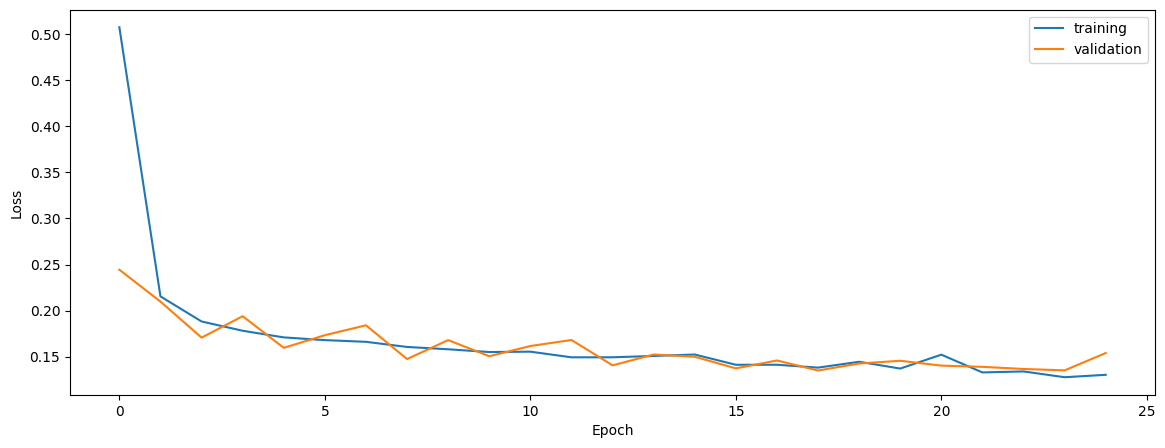

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.948815260820692
0.9468485387631379
0.9363629678652842


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.9499263291451037
0.9458672512745939
0.9368375250793063


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.9539425372048637
0.9527205301925333
0.9419939170044619


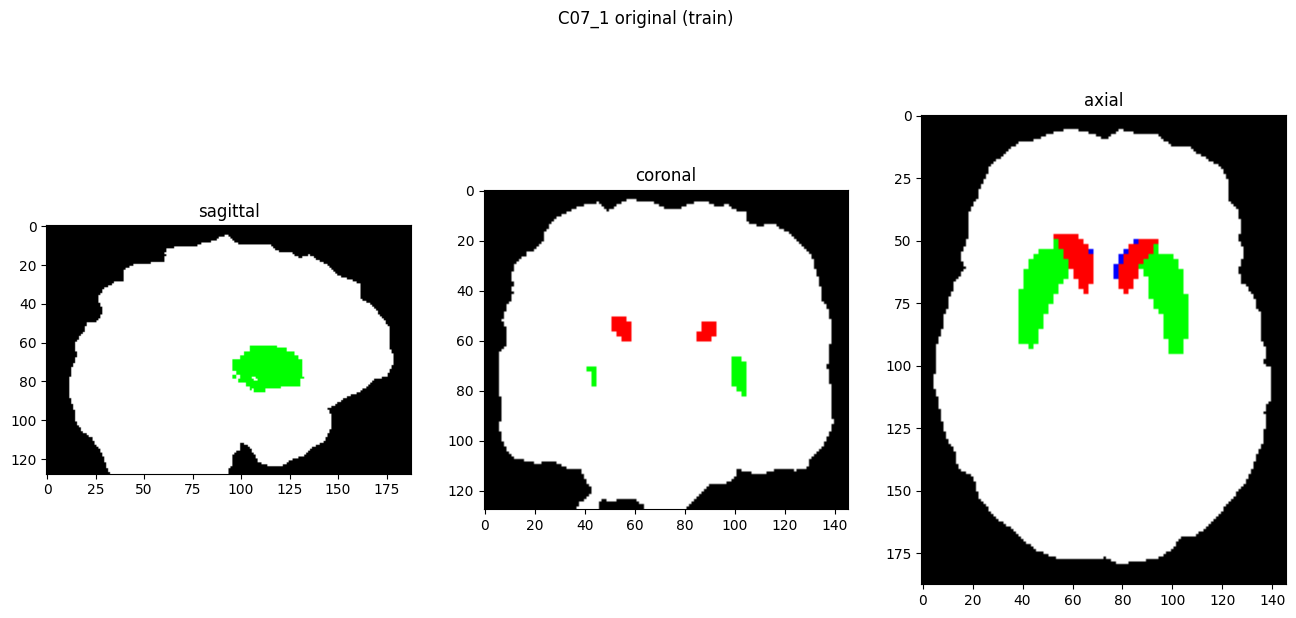

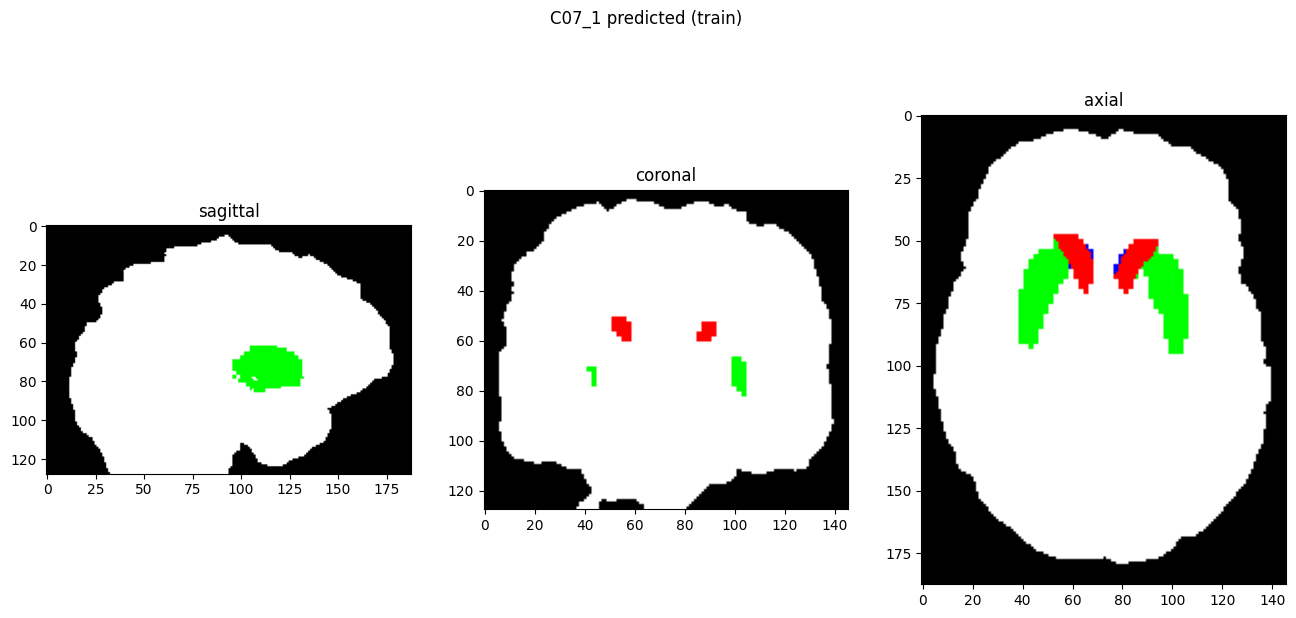

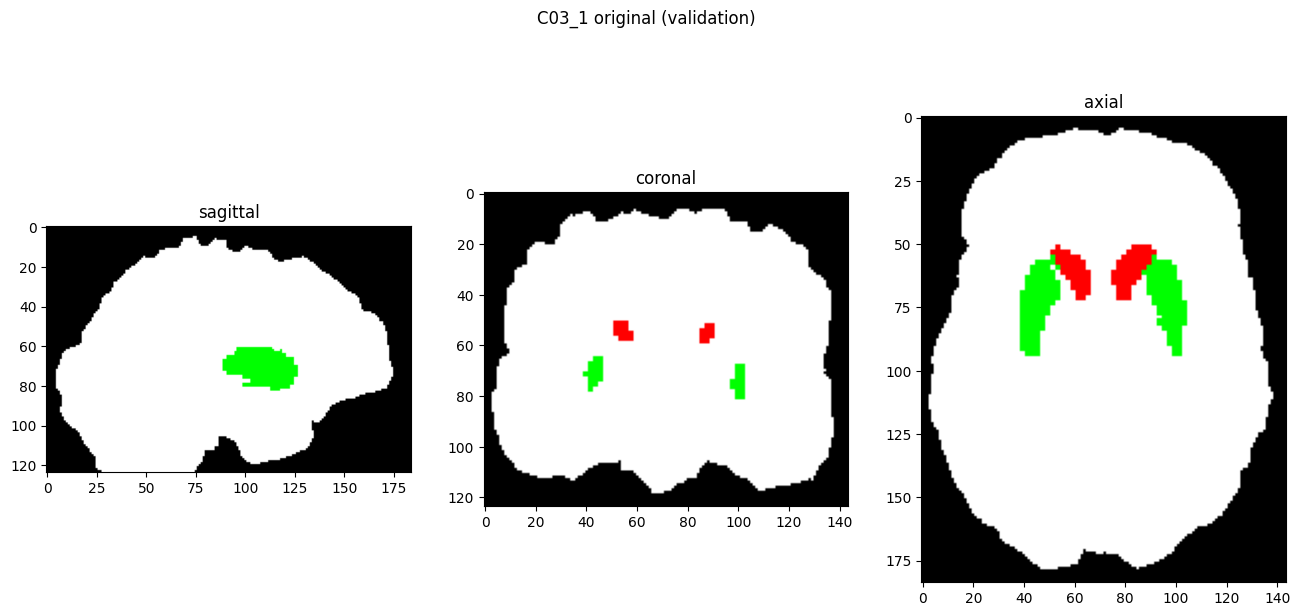

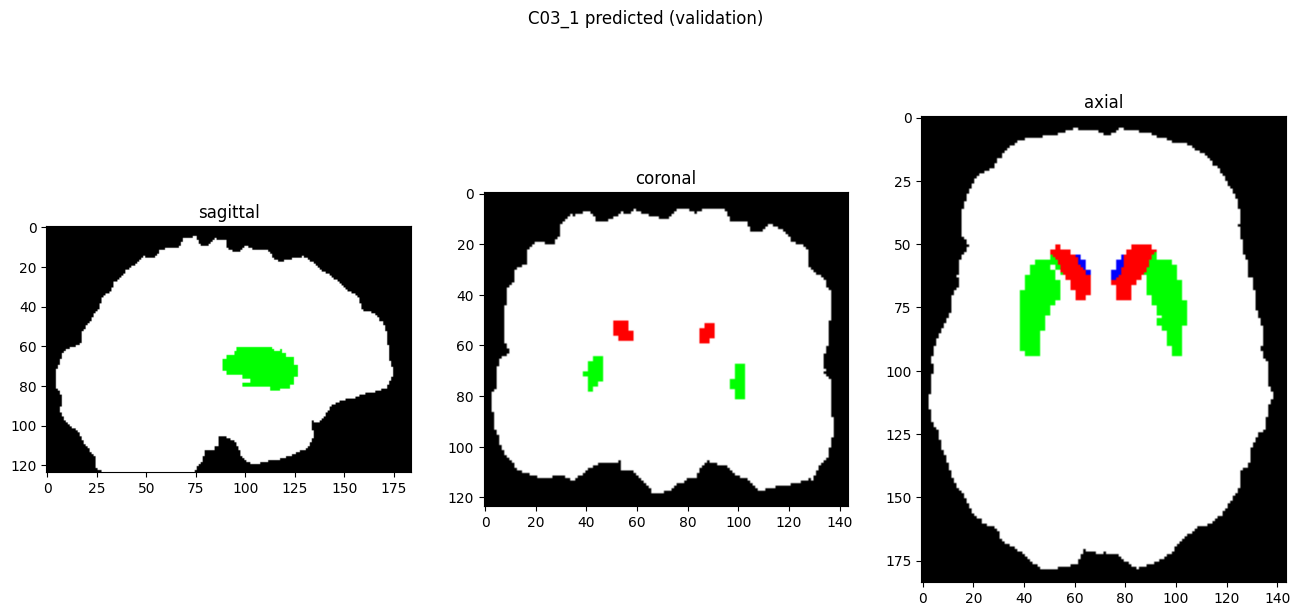

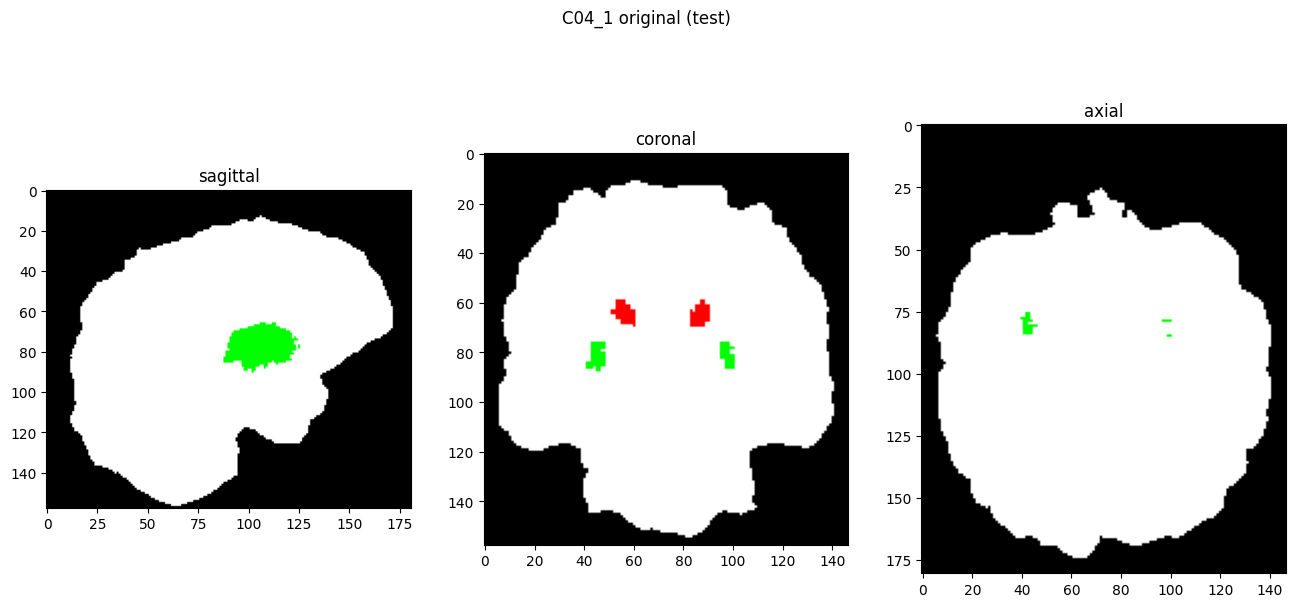

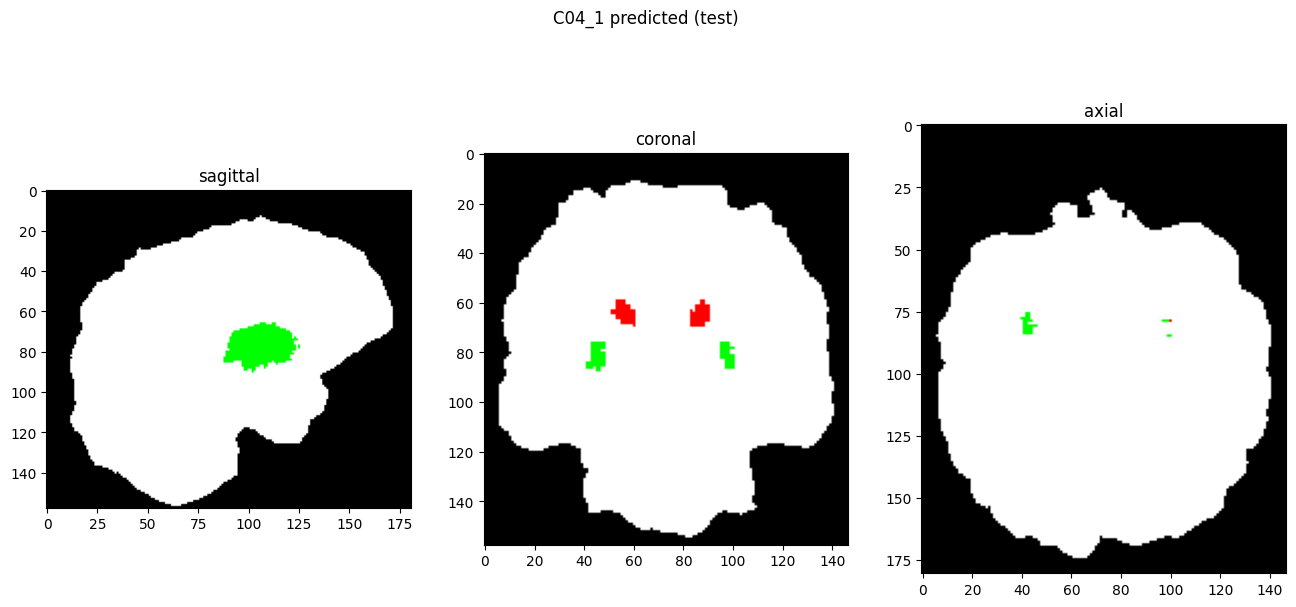

In [10]:
showResults(model, gen, threshold=0)